In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from scipy import stats
import glob
import os
import math
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import numpy as np
import scipy as sp
import umap
import umap.umap_ 
from scipy import stats
#import pegasus as pg
import glob
import os
from pvalannot import pvalannot

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

In [18]:
## Process meta data

In [2]:
metaInfo = pd.read_excel("merged_metadata.xlsx")
metaInfo["patient"] = metaInfo["patient"].astype(str)

tmpDf = pd.read_excel("MCL patient list_9.17.2024.xlsx") # This is mainly provide patient ID mapping information
tmpDf["MRN"] = tmpDf["MRN"].astype(str)
tmpDf = tmpDf[["Ran Patient ID", "MRN"]].rename({"Ran Patient ID":"MCL"}, axis=1)
tmpDf2 = pd.DataFrame({"MCL":["HD1", "HD2", "HD3"],
                      "MRN":["PBMC13", "PBMC16", "PBMC17"]})
tmpDf = pd.concat([tmpDf, tmpDf2])
metaInfo = metaInfo.merge(right=tmpDf, left_on="patient", right_on="MRN").drop("MRN", axis=1) 

In [3]:
mrnToMcl = {}
for i, r in tmpDf.iterrows():
    mrnToMcl[r["MRN"]] = r["MCL"]

In [5]:
reducedTimeColorMap = {}
for i,name in enumerate(["pre", "M1-3", "M4-", "normal"]):
    reducedTimeColorMap[name] = reducedTimeColors[i]

## Pilot study: Pickseq vs sortseq

In [2]:
pilotDf = pd.read_csv("pilot/tximport-counts.csv")
pilotDf = pilotDf.set_index("gene")

In [3]:
# Get the gene id->name conversion table
geneIdConversionDf = pd.read_csv("./cellranger_genes.tsv", sep="\t")
geneIdConversion = {}
for i, r in geneIdConversionDf.iterrows():
    geneIdConversion[r[0]] = r[1]
pilotDf.index = pilotDf.index.map(geneIdConversion)
pilotDf = pilotDf[ pd.notnull(pilotDf.index) ]

In [4]:
# Generate the anndata
pilotAdata = sc.AnnData(pilotDf.transpose())
pilotAdata.var_names_make_unique()
pilotAdata.obs["platform"] = pilotAdata.obs.index.str.split('_').str[3]
# Add metadata
#adata.obs = adata.obs.merge(metaInfo[["sample", "batch", "patient", "timepoint",
#                                     "picking", "cd19 expression"]], 
#                left_index=True, right_on="sample").set_index("sample")
#adata.obs.index.name = None

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### QC measures

In [12]:
# Inspect mitochondria gene
pilotAdata.var['mt'] = pilotAdata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(pilotAdata, qc_vars=['mt'], 
                               percent_top=None, log1p=False, inplace=True)

In [12]:
pvalannot.AddPvalAnnot

<function pvalannot.pvalannot.AddPvalAnnot(x, y, data, pairs=None, ax=None, hue=None, func=None, order=None, hue_order=None, font_scale=1, fmt=None, fig=None, padjust_func=None, pair_test_key=None, significant_p=0.05, margin=None, styles=None, change_ylim=True, func_args=None)>

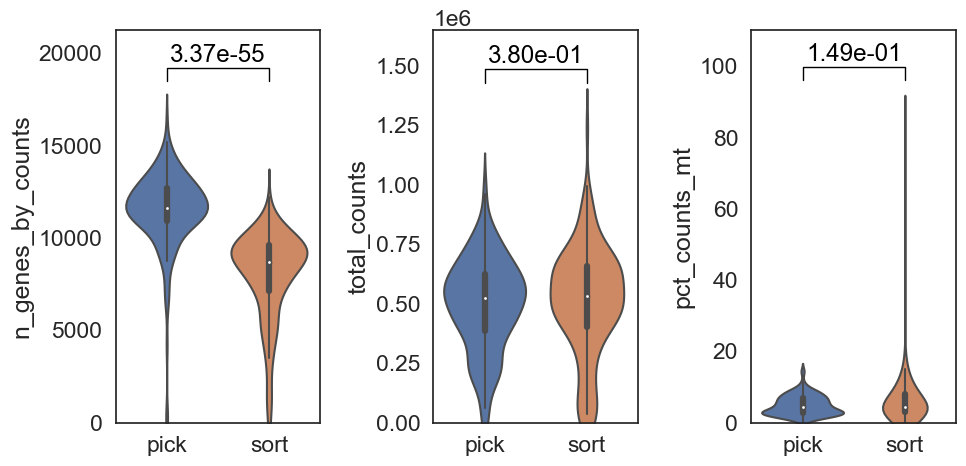

In [97]:
sns.set(style="white", font_scale=1.5)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, feature in enumerate(["n_genes_by_counts", "total_counts", "pct_counts_mt"]):
    ax=sns.violinplot(y=feature, data=pilotAdata.obs, x="platform",
                     order=["pick", "sort"],
                     saturation=0.75, ax=axes[i])
    pvalannot.AddPvalAnnot(y=feature, data=pilotAdata.obs, x="platform",
                     order=["pick", "sort"], ax=ax,
                     margin=(ax.get_ylim()[1] - ax.get_ylim()[0])/10)
    ax.set(ylim=(0, ax.get_ylim()[1]), xlabel="")
    #plt.show()
    #plt.tight_layout()
plt.tight_layout()
plt.savefig("pilot/pilot_qc.pdf", format="pdf")
plt.show()


### Unique genes identified in pickseq

In [5]:
pilotAdata.obs["platform"].value_counts()

platform
sort    288
pick    192
Name: count, dtype: int64

In [6]:
pickDf = pilotDf.filter(like="pick")
sortseqDf = pilotDf.filter(like="sort")

In [7]:
pickDf["pick_sum"] = pickDf.sum(axis=1)
sortseqDf["sort_sum"] = sortseqDf.sum(axis=1)

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_2024/3164462087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pickDf["pick_sum"] = pickDf.sum(axis=1)
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_2024/3164462087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortseqDf["sort_sum"] = sortseqDf.sum(axis=1)


In [8]:
sumDf = pickDf[["pick_sum"]]
sumDf["sort_sum"] = sortseqDf["sort_sum"]

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_2024/2698347488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumDf["sort_sum"] = sortseqDf["sort_sum"]


In [9]:
pickOnlyGenes = set(sumDf.loc[ (sumDf["pick_sum"] > 0) & (sumDf["sort_sum"]==0)].index)
sortOnlyGenes =  set(sumDf.loc[ (sumDf["pick_sum"] == 0) & (sumDf["sort_sum"]>0)].index)
bothGenes =  set(sumDf.loc[ (sumDf["pick_sum"] > 0) & (sumDf["sort_sum"]>0)].index)

In [51]:
from matplotlib_venn import venn2

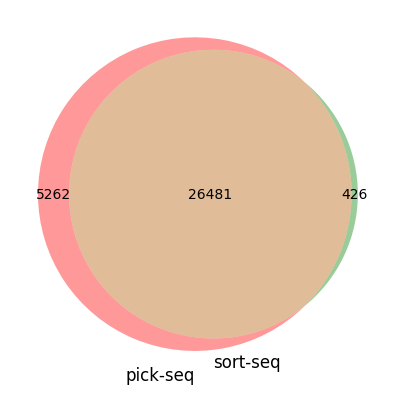

In [54]:
ax=venn2(subsets = (len(pickOnlyGenes), len(sortOnlyGenes), len(bothGenes)),
     set_labels= ("pick-seq", "sort-seq"))
plt.savefig("pilot/pilot_picksort_gene_venn.pdf", format="pdf")

In [10]:
cases = [pilotAdata.var.index.isin(pickOnlyGenes),
    pilotAdata.var.index.isin(sortOnlyGenes),
    pilotAdata.var.index.isin(bothGenes)]
pilotAdata.var["picksort"] = np.select(cases, ["pick-seq-only", "sort-seq-only", "both"], default=-1)

In [65]:
def hollowboxplot(data, x=None, y=None, hue=None, palette=None, ax=None, color=None, 
                  order=None, hue_order=None, jitter=True):
    snsFig = sns.boxplot(x=x, y=y, hue=hue, data=data, hue_order=hue_order, order=order,
                         showfliers = False, palette=palette, ax=ax)
    for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
             snsFig.lines[j].set_color(color)
    if (hue):
        snsFig = sns.stripplot(x=x, y=y, hue=hue, data=data, hue_order=hue_order, order=order,
                             jitter=jitter, dodge=True, palette=palette, ax=snsFig)
    else:
        snsFig = sns.stripplot(x=x, y=y, hue=x, data=data, hue_order=hue_order, order=order,
                             jitter=jitter, dodge=False, palette=palette, ax=snsFig)
    return snsFig

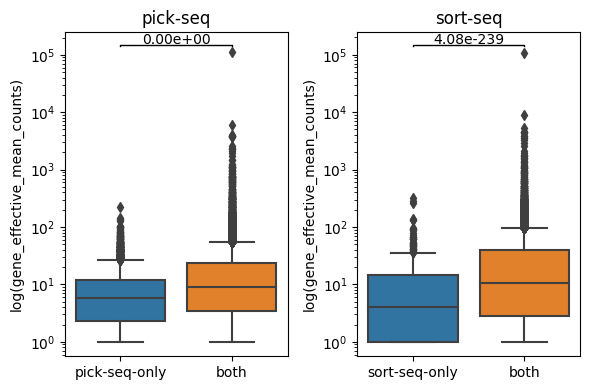

In [92]:
fig, axes = plt.subplots(1,2, figsize=(6,4))
for i,platform in enumerate(["pick", "sort"]):
    subAdata = pilotAdata[ pilotAdata.obs["platform"] == platform, :]
    dropColumns = list(subAdata.var.columns)
    dropColumns.remove("picksort")
    subAdata.var = subAdata.var.drop(dropColumns, axis=1)
    sc.pp.calculate_qc_metrics(subAdata, 
                        percent_top=None, log1p=False, inplace=True)
    subAdata.var["effective_mean_counts"] = subAdata.var["total_counts"] / subAdata.var["n_cells_by_counts"]
    ax=sns.boxplot(y="effective_mean_counts", data=subAdata.var, x="picksort",
            order=[f"{platform}-seq-only", "both"], ax=axes[i])
    ax.set(title=f"{platform}-seq", yscale="log", xlabel="", ylabel="log(gene_effective_mean_counts)") 
    pvalannot.AddPvalAnnot(y="mean_counts", data=pilotAdata.var, x="picksort",
            order=[f"{platform}-seq-only", "both"], ax=ax,
            margin=(ax.get_ylim()[1] - ax.get_ylim()[0])/5)
    
plt.tight_layout()
plt.savefig("pilot/pilot_picksort_gene_expr_effective_mean_count.pdf", format="pdf")

In [46]:
sc.pp.calculate_qc_metrics(subAdata, 
                        percent_top=None, log1p=False, inplace=True)

In [112]:
pickAdata = pilotAdata[ pilotAdata.obs["platform"] == "pick"]
sortAdata = pilotAdata[ pilotAdata.obs["platform"] == "sort"]

In [118]:
sc.pp.calculate_qc_metrics(pickAdata, 
                               percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(sortAdata, 
                               percent_top=None, log1p=False, inplace=True)

In [126]:
avgDf = pd.concat([pickAdata.var[["mean_counts"]], sortAdata.var[["mean_counts"]]],
                  axis=1)
avgDf.columns = ["pick_mean_counts", "sort_mean_counts"]

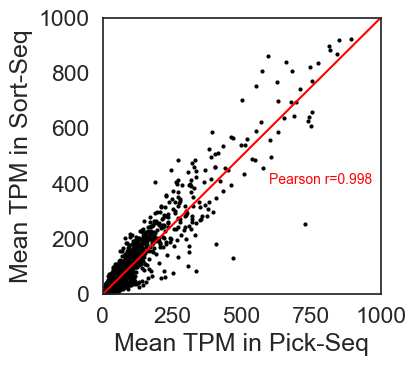

In [183]:
#ax = sns.scatterplot(data=avgDf, x="pick_mean_counts", y="sort_mean_counts")
plt.figure(figsize=(4.5,4))
ax = plt.gca()
ax.scatter(x=avgDf["pick_mean_counts"], y=avgDf["sort_mean_counts"],
          color="black", s=4, rasterized=True)
ax.plot([0, 1000], [0, 1000], color="red")
r = sp.stats.pearsonr(x=avgDf["pick_mean_counts"],
                y=avgDf["sort_mean_counts"])[0]
ax.text(x=600, y=400, s="Pearson r=%.3lf"%r, color="red",
       size=10)
ax.set(xlim=[0,1000], ylim=[0,1000], xlabel="Mean TPM in Pick-Seq", ylabel="Mean TPM in Sort-Seq")
plt.tight_layout()
plt.savefig("pilot/pilot_picksort_gene_expr_correlation.pdf", format="pdf",
           bbox_inches="tight", dpi=300)

In [139]:
np.quantile(pilotAdata.var["mean_counts"],q=0.99)

137.20000000000007

## Patient survival display

In [139]:
survivalDf = pd.read_excel("../data/Ran_MCL patient list_9.17.2024.xlsx").dropna(how="all")

In [259]:
survivalDf["forsort"] = survivalDf[["Days of ongoing remission", "Day of Death"]].max(axis=1)
survivalDf = survivalDf.sort_values(by="forsort", ascending=False)

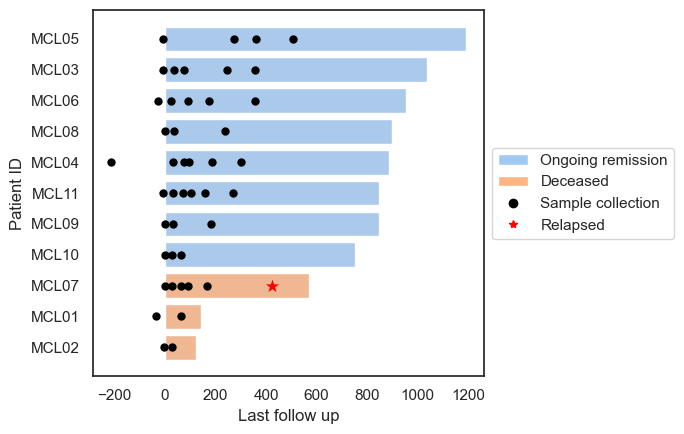

In [261]:
fig = plt.figure(figsize=(7, 4.5) )
sns.set(font_scale=1, style="white")
labels = ["Ongoing remission", "Deceased"]
#colors = [sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
colors = sns.color_palette("pastel")
orders = []
ax = sns.barplot(x="Days of ongoing remission", y="Ran Patient ID", data=survivalDf, color=colors[0])
ax = sns.barplot(x="Day of Death", y="Ran Patient ID", data=survivalDf, color=colors[1])
for i in range(1, 7):
    ax = sns.scatterplot(x="Day of sample%d collection"%i, y = "Ran Patient ID", data = survivalDf, color="black",
                        linewidth=0)
ax = sns.scatterplot(x = "Days of relapse", y = "Ran Patient ID", data = survivalDf, color="red", 
                     markers="*", style="Days of relapse", size="Days of relapse", sizes=[100],
                    linewidth=0)

legend_elements = []
for i in range(len(labels)):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=labels[i]))
legend_elements.append(Line2D([0], [0], marker='o', linestyle='',
                       color = "black", label="Sample collection"))
legend_elements.append(Line2D([0], [0], marker='*', linestyle='',
                       color = "red", label="Relapsed"))
ax.legend(handles = legend_elements, loc="center left", 
                 bbox_to_anchor = (1, 0.5))

ax.set(xlabel="Last follow up", ylabel="Patient ID")

plt.tight_layout()
plt.savefig("sample_collection.pdf", format="pdf")


## TRUST4_smart-seq analysis (bulk level)

In [156]:
trust4Airr = pd.read_csv("pickseq_smartseq_airr_wmeta.tsv", sep="\t", keep_default_na=False)
#metaInfo = pd.read_csv("merged_metadata.csv")

In [158]:
sampleCellCount = {}
for i, row in metaInfo.iterrows():
    sample = row["patient"] + "_" + row["timepoint"]
    if (sample not in sampleCellCount):
        sampleCellCount[sample] = 0 
    sampleCellCount[sample] += 1

## Calculate the clonality for each sample (sampleid+timepoint)

In [153]:
def GetChainType( v, j, c ):
    s = ""
    if ( v != "*" and v != "" ):
        s = v 
    elif ( j != "*" and v != ""):
        s = j
    elif ( c != "*" and v != ""):
        s = c
    else:
        return -1

    if ( s[0:3] == "IGH" ):
        return 0
    elif ( s[0:3] == "IGK" ):
        return 1
    elif ( s[0:3] == "IGL" ):
        return 1 
    elif ( s[0:3] == "TRA" ):
        return 3
    elif ( s[0:3] == "TRB" ):
        return 4
    elif ( s[0:3] == "TRG" ):
        return 5
    elif ( s[0:3] == "TRD" ):
        return 6
    
    return -1 

def GetGeneType( s ):
    if ( s[3] == "V" ):
        return 0 
    elif ( s[3] == "J" ):
        return 2
    elif (s[3] == "D"):
        if (len(s) == 4):
            return 3
        else:
            return 1
    elif ( s[3] == "-" ):
        return -1
    else:
        return 3
    
chainTypeToName = ("IGH", "IGK", "IGL", "TRA", "TRB", "TRG", "TRD" )
geneTypeToName = ("V", "J", "C" )

def GetMainGeneName( g ): # remove the allele type from the gene name
    fields = g.split( "*", 1 )
    return fields[0]

In [154]:
# Check the diversity change between filtered and not filtered samples
def ComputeEntropy(rep):
    if (len(rep) == 0):
        return 0
    total = sum(list(rep.values()))
    return sum([-x/total*math.log(x/total) for x in rep.values()])

def ComputeClonality(rep):
    if (len(rep) < 1):
        return 0
    if (len(rep) == 1):
        if (sum(list(rep.values())) >= 10):
            return 1
        else:
            return 0
    ret = 1 - ComputeEntropy(rep) / math.log(len(rep))
    if (ret < 1e-8):
        ret = 0
    return ret

def ComputeRichness(rep):
    return len(rep)

def ConvertToClonotypeFrequency(barcodeList):
    barcodeFreq = {}
    for barcode in barcodeList:
        if (barcode not in barcodeFreq):
            barcodeFreq[barcode] = 0
        barcodeFreq[barcode] += 1
    return barcodeFreq

def ParseCigar(cigar):
    cigarFields = re.findall("\d+\w", cigar)
    ret = []
    for f in cigarFields:
        ret.append( (int(f[0:-1]), f[-1]) )
    return ret

In [159]:
sampleCDR3 = {}
patientInfo = {}
cellType = {}
sampleToCells = {}
for i, row in trust4Airr.loc[trust4Airr.productive == 'T'].iterrows():
    sample = row["meta"]
    if (sample not in sampleCDR3):
        sampleCDR3[sample] = [[], [], [], [], [], [], []]
        sampleToCells[sample] = []
    chainType = GetChainType(row["v_call"], row["j_call"], row["c_call"])
    if (chainType <= 2):
        cellType[ row["cell"] ] = "B"
    else:
        cellType[ row["cell"] ] = "T"
    sampleCDR3[sample][chainType].append(row["junction"])
    sampleToCells[sample].append( row["cell"])
    patient = row["meta"].split("_")[0]
    if (patient not in patientInfo):
        patientInfo[patient] = {}
    patientInfo[patient][ row["meta"].split("_")[1] ] = 1 
    
for sample in sampleCellCount:
    if (sample not in sampleCDR3):
        sampleCDR3[sample] = [[], [], [], [], [], [], []]
        sampleToCells[sample] = []
        patient = sample.split("_")[0]
        if (patient not in patientInfo):
            patientInfo[patient] = {}
        patientInfo[patient][ sample.split("_")[1] ] = 1 

In [161]:
chain = 0
sampleDiversity = {}
for sample in sampleCDR3:
    #if (len(sampleCDR3[sample][chain]) < 5):
    #    continue 
    rep = ConvertToClonotypeFrequency(sampleCDR3[sample][chain])
    tcrAbund = 0
    for c in sampleToCells[sample]:
        if (cellType[c] != 'B'):
            tcrAbund += 1
    sampleDiversity[sample] = {
        "entropy": ComputeEntropy(rep),
        "clonality": ComputeClonality(rep),
        "abundance": sum(list(rep.values())),
        "richness": ComputeRichness(rep),
        "igh_recall" if (chain == 0) else "iglk_recall": sum(list(rep.values())) / sampleCellCount[sample], 
        "tcr_abund": tcrAbund,
        "tcr_recall": tcrAbund / sampleCellCount[sample],
        "cell_count": sampleCellCount[sample]
        }
       

In [162]:
diversityList = ["entropy", "clonality", "abundance", "richness", 
                 "igh_recall" if (chain == 0) else "iglk_recall", "tcr_abund", "tcr_recall", "cell_count"]
samplev = []
mclv = []
timev = []
patientv = []
for sample in sampleDiversity:
    samplev.append(sample)
    subCols = sample.split("_")
    patient = mrnToMcl[subCols[0]]
    if (len(subCols) > 2):
        patient = patient + "_" + subCols[-1]
    #patientv.append(mrnToMcl[sample.split("_")[0]])
    patientv.append(patient)
    if ("PBMC" in sample):
        if ("CD5" in sample):
            timev.append("M3")
        else:
            timev.append("pre")        
    else:
        timev.append(sample.split("_")[1])
diversityDf = pd.DataFrame({"sample":samplev, "time":timev, "donor":patientv})
for diversity in diversityList:
    v = []
    for sample in sampleDiversity:
        v.append(sampleDiversity[sample][diversity])
    diversityDf[diversity] = v

In [163]:
diversityDf = diversityDf.replace('d28', 'M1')

In [164]:
# Add a column for reduced time point
reduceTimeMap = {}
for t in ["pre"]:
    reduceTimeMap[t] = "pre"
for t in ["M1", "M2", "M3"]:
    reduceTimeMap[t] = "M1-3"
for t in ["M6", "M9", "M12"]:
    reduceTimeMap[t] = "M4-"   
diversityDf["reduced_time"] = diversityDf["time"].map(reduceTimeMap)

In [165]:
diversityDf.to_csv("sample_diveresity.csv")

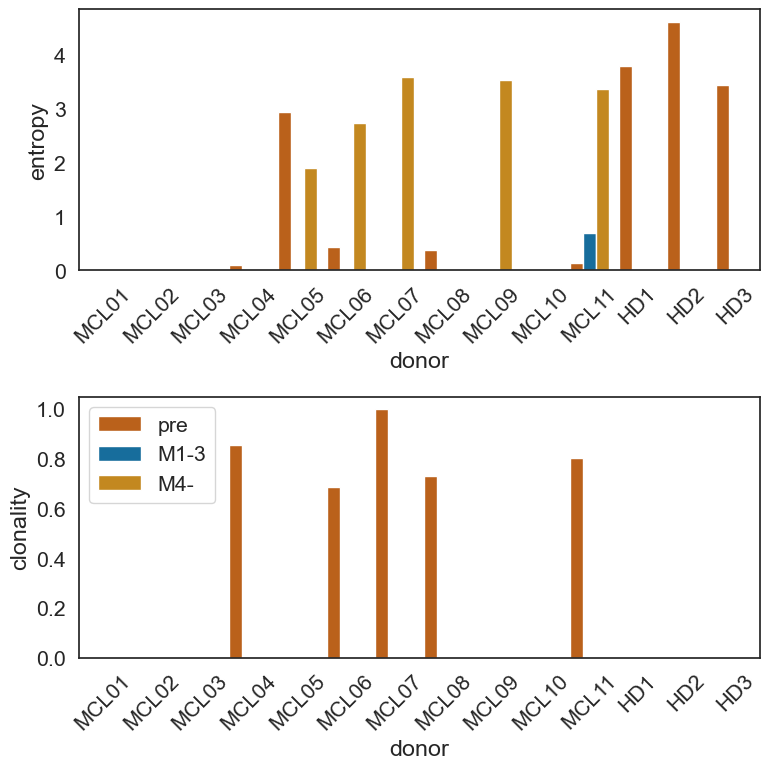

In [332]:
sns.set(style="white", font_scale=1.4)
hueOrder = ["pre", "M1-3", "M4-"]
xorder = [x for x in sorted(diversityDf["donor"].unique()) if '_' not in x]
xorder = sorted(xorder, key = lambda x: 'Z' + x if (x.startswith('H')) else x)
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
colors = sns.color_palette("colorblind")[0:10]
colors = [colors[3], colors[0], [252/255,230/255,33/255], colors[2]]
for i, diversity in enumerate(["entropy", "clonality"]):
    groupDf = diversityDf.groupby(["donor","reduced_time"])[diversity].mean().reset_index()
    ax = sns.barplot(x="donor", y=diversity, data=groupDf, hue="reduced_time",
                    order = xorder, hue_order = hueOrder, ax=axes[i],
                    palette = reducedTimeColors)
    #ax.set(title=diversity)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    if (i != 1):
        ax.get_legend().remove()
    else:
        ax.legend()
        #ax.legend(loc="lower left", bbox_to_anchor=[0.8,0])
fig.tight_layout()
plt.savefig("sample_focused_diversity_chain"+str(chain)+"_reducedTime.pdf", format="pdf")

## Single-cell RNA-seq analysis

In [7]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import numpy as np
import scipy as sp
import umap
import umap.umap_ 
from scipy import stats
#import pegasus as pg
import glob
import os

In [236]:
combinedTPM = pd.DataFrame()
for batch in range(1, 5):
    batchTPM = pd.read_csv("TPM/batch%d_tximport-tpm.csv"%batch) 
    batchTPM = batchTPM.set_index("gene")
    print(batch, len(batchTPM))
    # rename the header to cell id
    batchTPM = batchTPM.add_prefix("batch%d_"%batch)
    if (batch == 1):
        combinedTPM = batchTPM
    else:
        combinedTPM = combinedTPM.merge(batchTPM, left_index=True, right_index=True)
combinedTPM.index = batchTPM.index.map(geneIdConversion) # rename the gene id
combinedTPM = combinedTPM[ pd.notnull(combinedTPM.index) ]
#combinedTPM = combinedTPM.groupby("gene").sum()

1 58735
2 58735
3 58735
4 58735


In [273]:
adata.obs["batch"].value_counts()

batch
batch4    473
batch2    468
batch3    448
batch1    420
Name: count, dtype: int64

In [277]:
adata.obs[(adata.obs["batch"] == "batch1")]["patient"].value_counts()

patient
MCL03    188
MCL01     89
HD1       48
HD2       48
MCL02     47
Name: count, dtype: int64

In [213]:
# cutoff: <1, quantile of pct_counts_mt. 
#         >=1, keep cells value of <= pct_counts_mt
# @return: new adata
def RemoveMTCell(adata, cutoff):
    # annotate the group of mitochondrial genes as 'mt'
    origLen = len(adata)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], 
                               percent_top=None, log1p=False, inplace=True)
    if (cutoff >= 1):
        return adata[adata.obs.pct_counts_mt <= cutoff, :]
    else:
        pctCutoff = np.quantile(adata.obs.pct_counts_mt, cutoff)
        return adata[adata.obs.pct_counts_mt < pctCutoff, :]

In [238]:
# Load in meta data
adata = sc.AnnData(combinedTPM.transpose())
adata.var_names_make_unique()

# Add metadata
adata.obs = adata.obs.merge(metaInfo[["sample", "batch", "patient", "timepoint",
                                     "picking", "cd19 expression"]], 
                left_index=True, right_on="sample").set_index("sample")
adata.obs.index.name = None
#adata = adata[~adata.obs.batch.isna()]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [216]:
# Inspect mitochondria gene
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], 
                               percent_top=None, log1p=False, inplace=True)

In [146]:
obsqc, varqc = sc.pp.calculate_qc_metrics(adata, log1p=False)

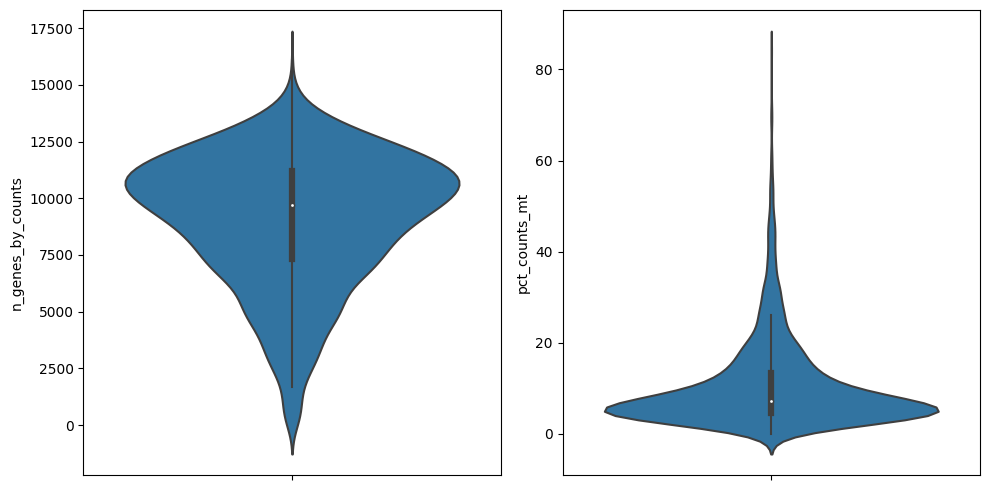

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.violinplot( y="n_genes_by_counts", data=obsqc, ax = ax[0])
sns.violinplot(y="pct_counts_mt", data=adata.obs, ax=ax[1])
plt.tight_layout()
#plt.savefig("SMART-seq/qcplot.pdf", format="pdf")

In [217]:
# QC plot for final figure
reduceTimeMap = {}
for t in ["pre"]:
    reduceTimeMap[t] = "pre"
for t in ["M1", "M2", "M3"]:
    reduceTimeMap[t] = "M1-3"
for t in ["M6", "M9", "M12"]:
    reduceTimeMap[t] = "M4-"   
for t in ["normal"]:
    reduceTimeMap[t] = "normal"
adata.obs["reduced_time"] = adata.obs["timepoint"].map(reduceTimeMap)

In [311]:
sns.color_palette(reducedTimeColors, desat=0.75)[0]

(0.7308823529411765, 0.3808823529411765, 0.10441176470588232)

In [309]:
reducedTimeColors

[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (1, 1, 0),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

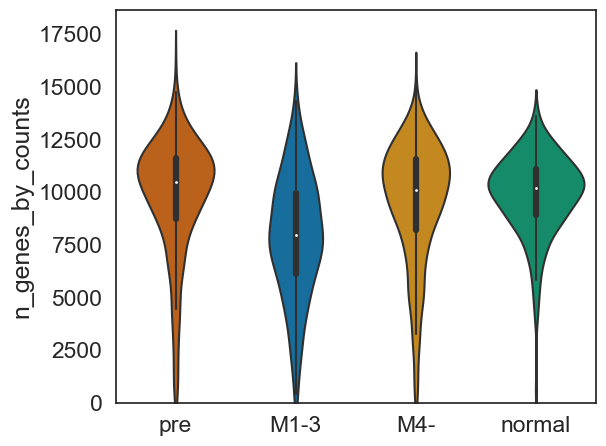

In [333]:
sns.set(style="white", font_scale=1.5, palette="bright")
ax=sns.violinplot(y="n_genes_by_counts", data=adata.obs, x="reduced_time",
                 order=["pre", "M1-3", "M4-", "normal"],
                 palette=reducedTimeColors, saturation=0.75)
ax.set(ylim=(0, ax.get_ylim()[1]), xlabel="")
plt.tight_layout()
plt.savefig("SMART-seq/qc_genesbycounts.pdf")


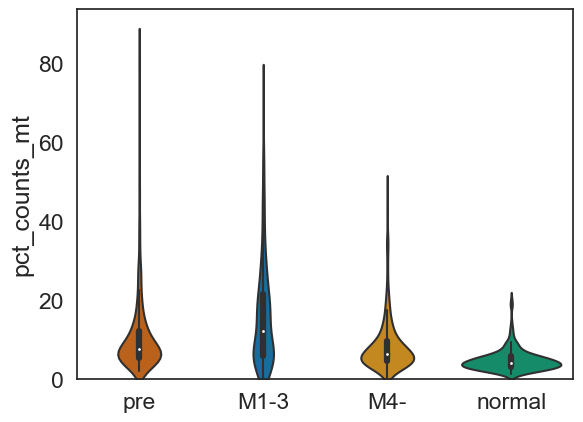

In [334]:
ax=sns.violinplot(y="pct_counts_mt", data=adata.obs, x="reduced_time",
                 order=["pre", "M1-3", "M4-", "normal"],
                 palette=reducedTimeColors)
ax.set(ylim=(0, ax.get_ylim()[1]), xlabel="")
plt.savefig("SMART-seq/qc_mtpct.pdf")

In [25]:
np.array(adata.X).sum(axis=0)

array([ 6221.283223, 18647.128641,  5216.8494  , ...,  7897.050408,
        2335.540128,  5952.481306])

In [48]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=2000)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


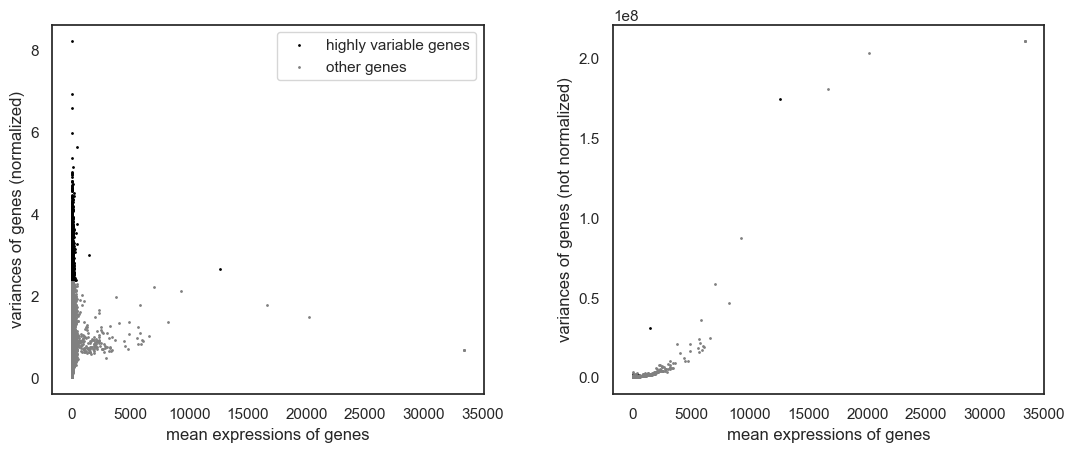

In [49]:
sc.pl.highly_variable_genes(adata)

In [50]:
adata.raw = adata

In [51]:
adata = adata[:, adata.var.highly_variable]

In [52]:
#sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [88]:
adata.obs

batch patient timepoint picking cd19 expression  \
batch1_S1    batch1     HD1    normal       D             pos   
batch1_S10   batch1     HD1    normal       D             pos   
batch1_S100  batch1   MCL03       pre       S             pos   
batch1_S101  batch1   MCL03       pre       D             pos   
batch1_S102  batch1   MCL03       pre       D             pos   
...             ...     ...       ...     ...             ...   
batch4_S95   batch4   MCL08        M1       D             pos   
batch4_S96   batch4   MCL08        M1       S             pos   
batch4_S97   batch4   MCL08        M1       D             pos   
batch4_S98   batch4   MCL08        M1       D             neg   
batch4_S99   batch4   MCL08        M1       D             pos   

             n_genes_by_counts   total_counts  total_counts_mt  pct_counts_mt  \
batch1_S1                 9753  828690.973979     57756.243776       6.969576   
batch1_S10               10188  854050.840136     38392.017611       4.495285   
batch1_S100              11248  827730.086682     53239.283250       6.431962   
batch1_S101               9026  908373.480852     41163.609974       4.531573   
batch1_S102               4738  889274.342253     34622.911165       3.893389   
...                        ...            ...              ...            ...   
batch4_S95                5706  828051.723576    153651.310291      18.555762   
batch4_S96                6341  755590.221229    143769.890304      19.027495   
batch4_S97                9039  796180.808463     60950.068853       7.655305   
batch4_S98                7781  791343.784788    122691.448853      15.504191   
batch4_S99                9971  770191.843409     71265.097520       9.252902   

            leiden_1.0 raw_pateint reduced_time  
batch1_S1            3      PBMC13       normal  
batch1_S10           2      PBMC13       normal  
batch1_S100          4      753528          pre  
batch1_S101          4      753528          pre  
batch1_S102          4      753528          pre  
...                ...         ...          ...  
batch4_S95           0      693381         M1-3  
batch4_S96           0      693381         M1-3  
batch4_S97           0      693381         M1-3  
batch4_S98           0      693381         M1-3  
batch4_S99           0      693381         M1-3  

[1683 rows x 12 columns]

In [53]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

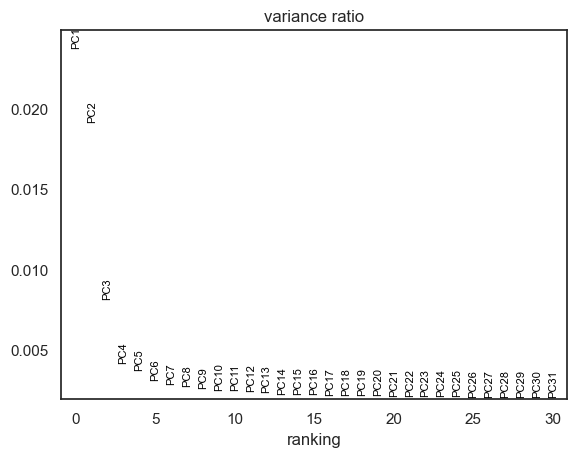

In [54]:
sc.pl.pca_variance_ratio(adata, log=False)

In [55]:
sc.external.pp.harmony_integrate(adata, key = "batch", plot_convergence=True,
                                max_iter_harmony=20)

2024-09-03 12:55:28,626 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-03 12:55:29,176 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-03 12:55:29,205 - harmonypy - INFO - Iteration 1 of 20
2024-09-03 12:55:29,556 - harmonypy - INFO - Iteration 2 of 20
2024-09-03 12:55:29,767 - harmonypy - INFO - Iteration 3 of 20
2024-09-03 12:55:29,949 - harmonypy - INFO - Iteration 4 of 20
2024-09-03 12:55:30,142 - harmonypy - INFO - Iteration 5 of 20
2024-09-03 12:55:30,296 - harmonypy - INFO - Iteration 6 of 20
2024-09-03 12:55:30,436 - harmonypy - INFO - Iteration 7 of 20
2024-09-03 12:55:30,587 - harmonypy - INFO - Iteration 8 of 20
2024-09-03 12:55:30,720 - harmonypy - INFO - Converged after 8 iterations


In [25]:
adata.obsm["X_pca_harmony"]

array([[-1.7660210e+00, -7.3338699e+00,  3.3854303e+00, ...,
        -7.6154657e-02,  3.8613775e-01, -8.3149815e-01],
       [-6.3429987e-01, -3.5488803e+00, -3.4187850e-01, ...,
        -2.9291415e+00,  5.8581525e-01, -3.3839099e+00],
       [ 1.5430422e+00,  1.7588103e-01,  6.0058379e+00, ...,
        -7.8249639e-01, -9.2589891e-01, -2.9016483e-01],
       ...,
       [-5.8559055e+00,  2.8687685e+00,  1.1603284e+00, ...,
         1.3489540e-01,  1.1973121e+00, -2.5488302e-01],
       [-8.9169970e+00, -1.4575560e+00,  3.5292566e-01, ...,
         3.2444981e-01, -1.2519459e+00, -8.2360566e-01],
       [-2.9897809e+00,  5.1446524e+00,  8.6778784e-03, ...,
        -3.9035132e+00,  1.2868737e+00, -5.5303484e-01]], dtype=float32)

In [38]:
import sklearn
sklearn.__version__

'1.0.2'

In [43]:
import harmonypy
harmonypy.__file__

'/Users/lsong/opt/anaconda3/lib/python3.9/site-packages/harmonypy/__init__.py'

In [56]:
reducer = umap.umap_.UMAP(random_state=17)
embedding = reducer.fit_transform( adata.obsm["X_pca_harmony"])

In [57]:
adata.obsm["X_umap"] = embedding

In [268]:
adata

AnnData object with n_obs × n_vars = 1683 × 2000
    obs: 'batch', 'patient', 'timepoint', 'picking', 'cd19 expression', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_1.0', 'raw_pateint', 'scSnpMarker_category', 'reduced_time', 't4type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'imrep', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'cd19 expression_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_66954/1169254095.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


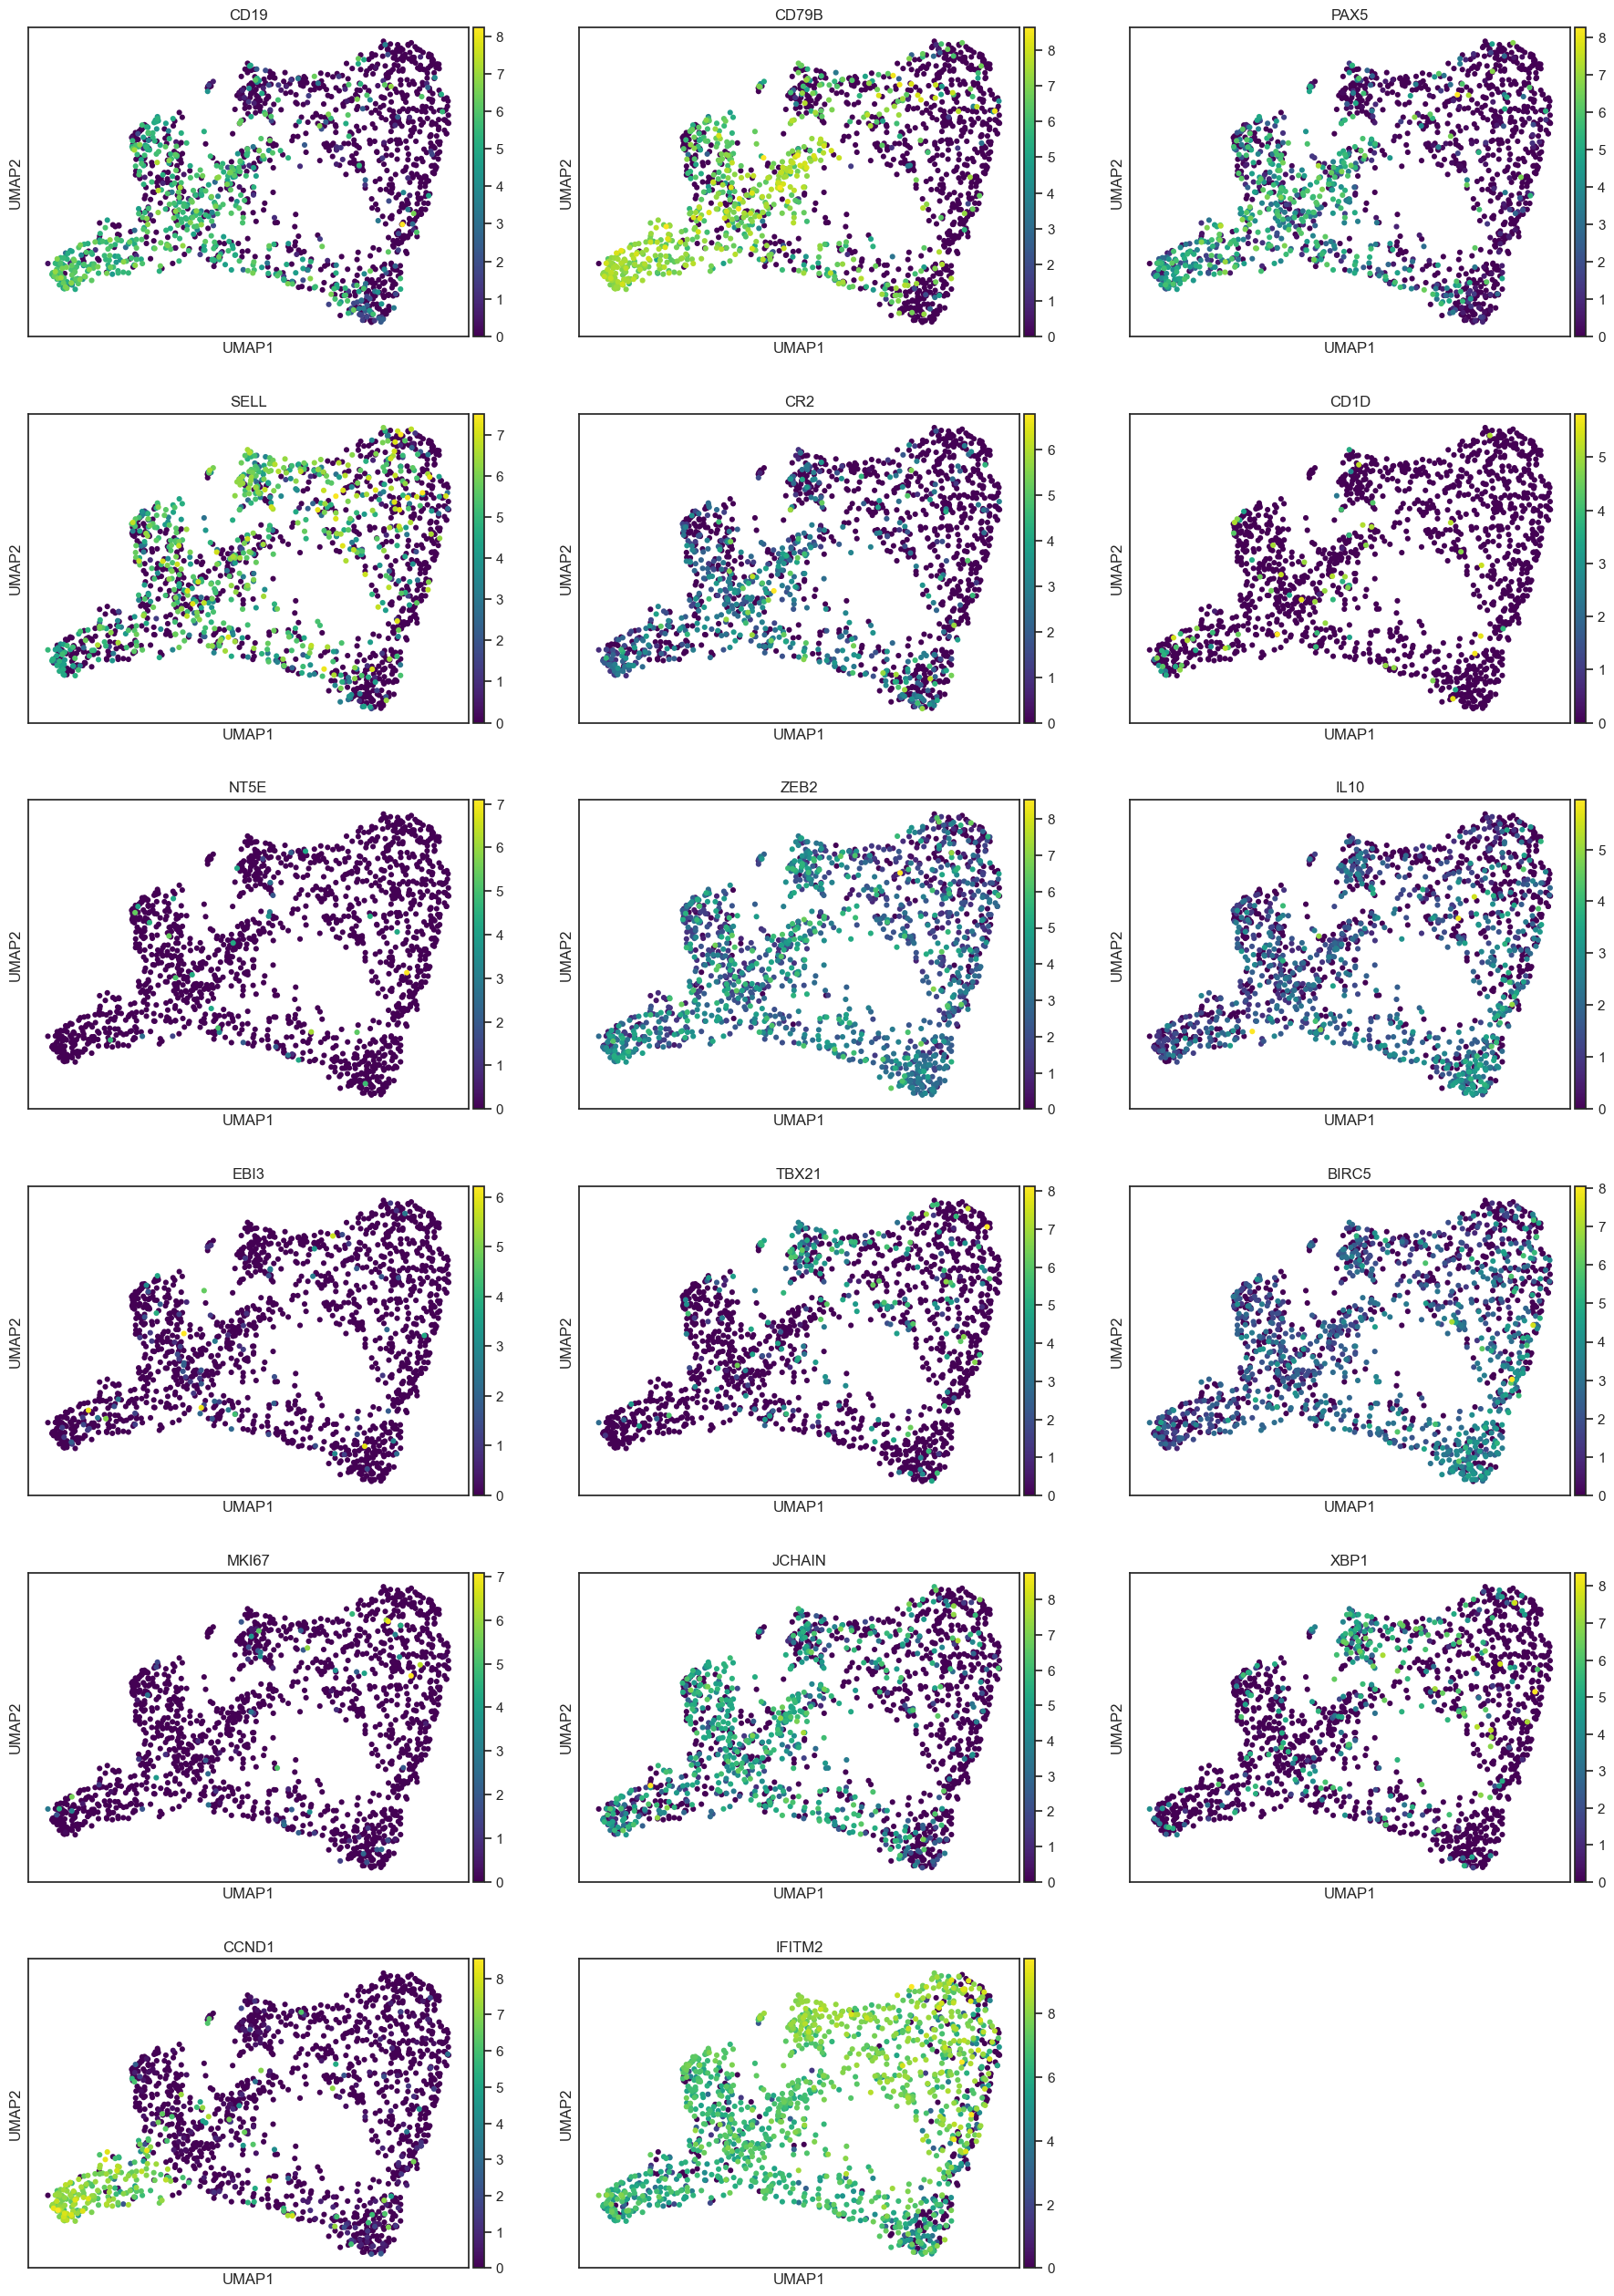

In [71]:
import matplotlib as mpl
sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList)], color=["CD19", "CD79B", "PAX5", 
                         "SELL", "CR2", "CD1D", "NT5E", "ZEB2",
                         "IL10", "EBI3",  "TBX21",
                         "BIRC5", "MKI67", "JCHAIN", "XBP1", "CCND1",
                        "IFITM2"]
                        , ncols=3, show=False, color_map=mpl.cm.viridis)
plt.tight_layout()

plt.savefig("SMART-seq/umap_marker_genes.pdf", format="pdf")

#"CD179A", "FCER2A", "CD11C",

In [136]:
adata.obsm["X_umap"]

array([[ 9.186961 ,  6.954808 ],
       [ 8.627806 ,  6.4105067],
       [11.565695 ,  7.1839304],
       ...,
       [14.294841 ,  5.4097953],
       [14.312956 ,  6.8992662],
       [14.265991 ,  4.5695877]], dtype=float32)

In [58]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca_harmony")

In [59]:
#sc.tl.leiden(adata, key_added = "leiden_0.5", resolution = 0.5)
sc.tl.leiden(adata, key_added = "leiden_1.0", resolution = 1.0)
#sc.tl.leiden(adata, key_added = "leiden_1.5", resolution = 1.5)

In [60]:
adata.obs["leiden_1.0"].value_counts()

leiden_1.0
0     308
1     245
2     242
3     218
4     194
5     193
6     151
7      76
8      16
9      15
10     14
11     11
Name: count, dtype: int64

In [10]:
adata.obs["leiden_1.0"].value_counts()

leiden_1.0
0     324
1     270
2     261
3     170
4     150
5     149
6     129
7     112
8      63
9      16
10     16
11     15
12      8
Name: count, dtype: int64

In [11]:
# FOR FINAL FIGURE
clusterCnt = 7
inclusion = []
clusterList = []
for i in range(clusterCnt):
    inclusion.append(str(i))
    clusterList.append(str(i))

#### Main UMAP

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


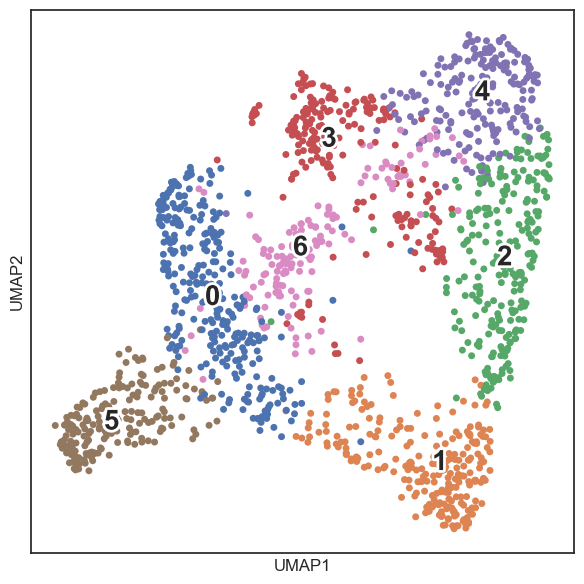

In [342]:
# FOR FINAL FIGURE
# A selected subset of clusters
sns.set(style="white", font_scale=1)
with plt.rc_context({"figure.figsize": (6, 6)}):
    ax = sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList) ], color=['leiden_1.0'],
          legend_loc='on data', legend_fontoutline=4, legend_fontsize=20, show=False, ncols=1,
           size=100)
    ax.set(title="")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_included_clusterId.pdf", format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


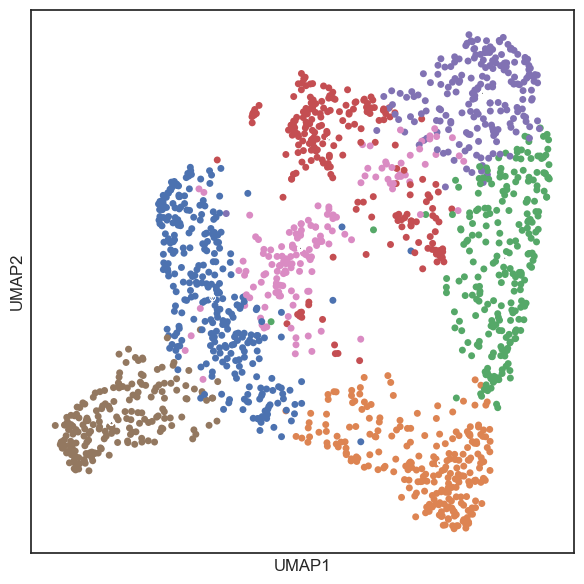

In [344]:
# FOR FINAL FIGURE
# A selected subset of clusters
sns.set(style="white", font_scale=1)
with plt.rc_context({"figure.figsize": (6, 6)}):
    ax = sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList) ], color=['leiden_1.0'],
          legend_loc='on data', legend_fontoutline=4, legend_fontsize=0, show=False, ncols=1,
           size=100)
    ax.set(title="")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_included_woclusterId.pdf", format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


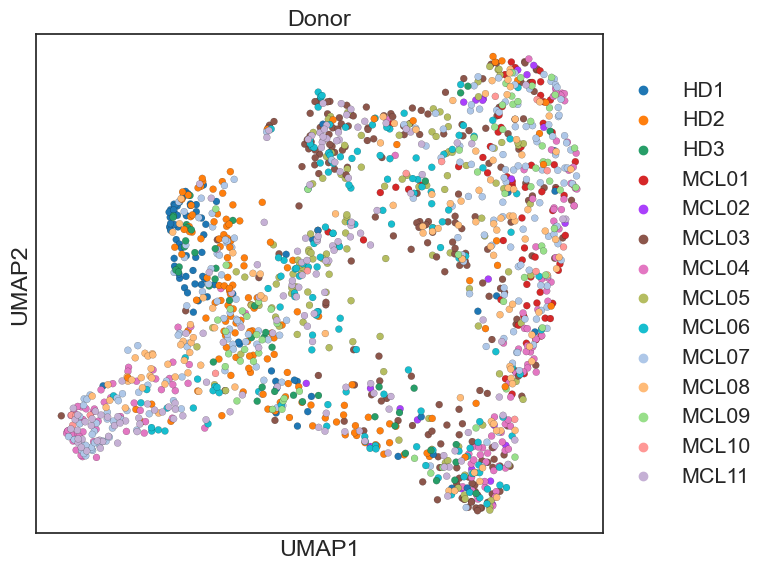

In [181]:
# FOR FINAL FIGURE
# Umap for paitent
with plt.rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList) ], color=['patient'],
         show=False, ncols=1, linewidth=0.1, edgecolor=[0,0,0],
           size=100)
    ax.set( title="Donor")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_included_patient.pdf", format="pdf")

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_66954/3085291769.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subAdata.obs["timepoint"] = subAdata.obs["timepoint"].astype("category")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


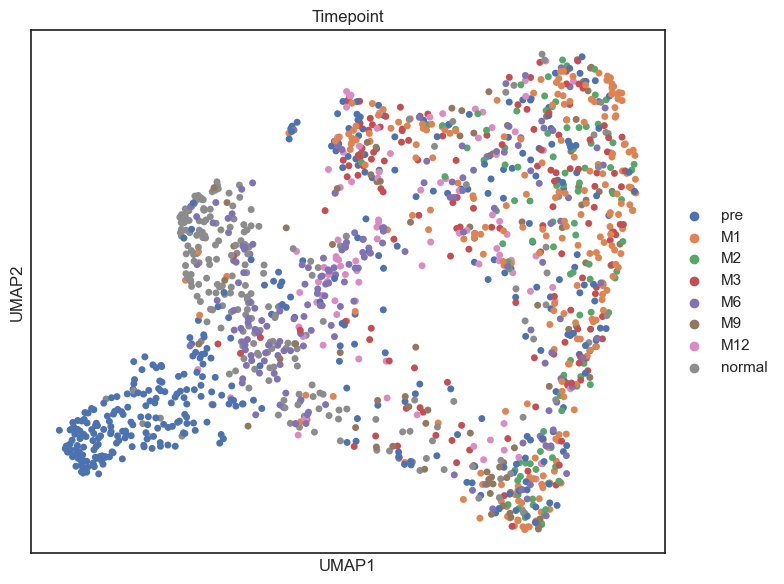

In [75]:
# FOR FINAL FIGURE
# Umap for timepoint
selectedTime = ["pre", "M1", "M2", "M3", "M6", "M9", "M12", "normal"]

subAdata = adata[ (adata.obs["leiden_1.0"].isin(clusterList))
                    & (adata.obs["timepoint"].isin(selectedTime))]
subAdata.obs["timepoint"] = subAdata.obs["timepoint"].astype("category")
subAdata.obs["timepoint"] = subAdata.obs["timepoint"].cat.reorder_categories(selectedTime)
with plt.rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.umap(subAdata, color=['timepoint'],
         show=False, ncols=1, na_in_legend=False, 
           size=100)
    ax.set(title="Timepoint")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_included_timepoint.pdf", format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


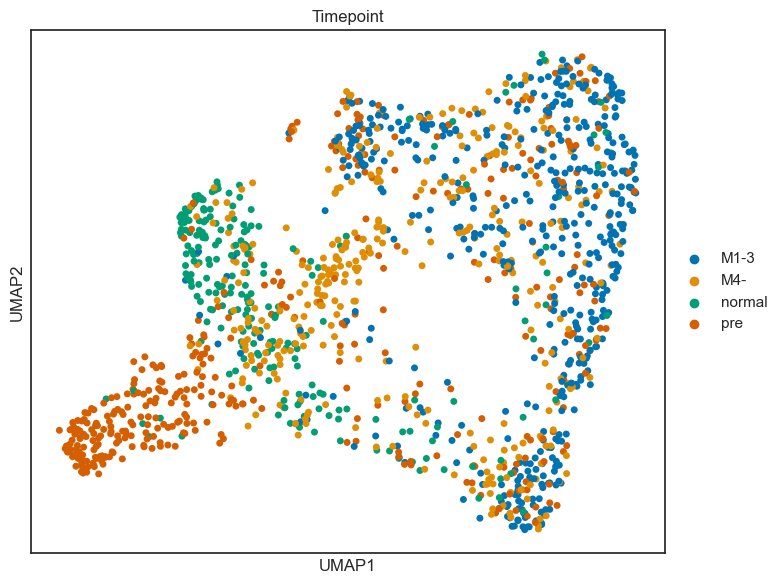

In [351]:
# FOR FINAL FIGURE
# Umap for reduced timepoint
selectedTime = ["pre", "M1-3", "M4-", "normal"]

subAdata = adata[ (adata.obs["leiden_1.0"].isin(clusterList))
                    & (adata.obs["reduced_time"].isin(selectedTime))]
#subAdata.obs["reduced_time"] = subAdata.obs["reduced_time"].astype("category")
#subAdata.obs["reduced_time"] = subAdata.obs["reduced_time"].cat.reorder_categories(selectedTime)
with plt.rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.umap(subAdata, color=['reduced_time'],
         show=False, ncols=1, na_in_legend=False, 
           size=100, 
           palette=reducedTimeColorMap)
    ax.set(title="Timepoint")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_included_reduced_timepoint.pdf", format="pdf")

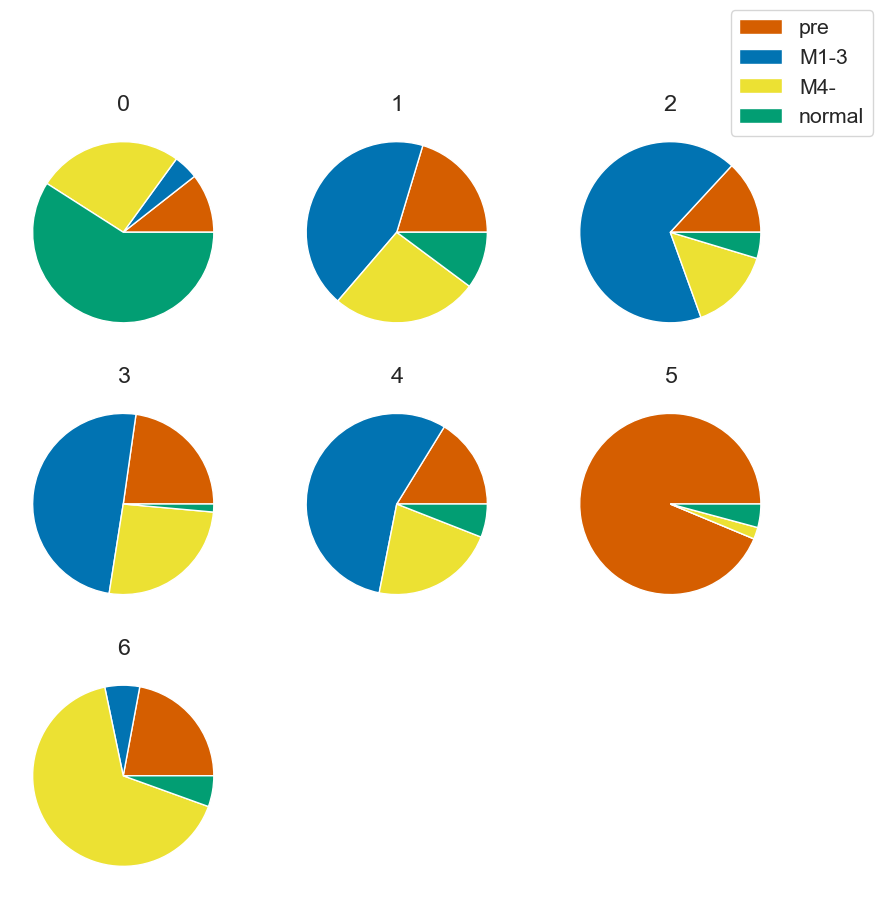

In [174]:
# FOR FINAL FIGURE
# Cluster's timepoint pie chart
selectedTime = {"pre":0, "M1-3":1, "M4-":2, "normal":3}
colors = sns.color_palette("colorblind")[0:9]
colors = [colors[3], colors[0], colors[8], colors[2]]
labels = [key for key in sorted(selectedTime.keys(), key=lambda x:selectedTime[x])]

subAdata = adata[ (adata.obs["leiden_1.0"].isin(clusterList))]
                    #& (adata.obs["reduced_time"].isin(selectedTime))]
fig, axes = plt.subplots(nrows=int(np.ceil(len(clusterList)/3)), ncols=3, figsize=(10, 10))
for i, ax in enumerate(fig.axes):
    if (i >= clusterCnt):
        ax.axis('off')
        continue
    subdf = subAdata.obs.loc[ subAdata.obs["leiden_1.0"] == str(i)]
    s=subdf["reduced_time"].value_counts()
    pie=[0,0,0,0]
    total=0
    for t,c in s.items():
        if (t in selectedTime):
            pie[selectedTime[t]] = c
        total += c
    pie = np.array(pie) / total
    ax.set(title=str(i))
    ax.pie(pie, colors=colors)#, labels = selectedTime.keys())
fig.legend(labels=labels)
plt.savefig("SMART-seq/composition_cluster_pie_timepoint.pdf", format="pdf")

In [15]:
s=adata[adata.obs["leiden_1.0"]=='1'].obs["reduced_time"].value_counts()

In [53]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


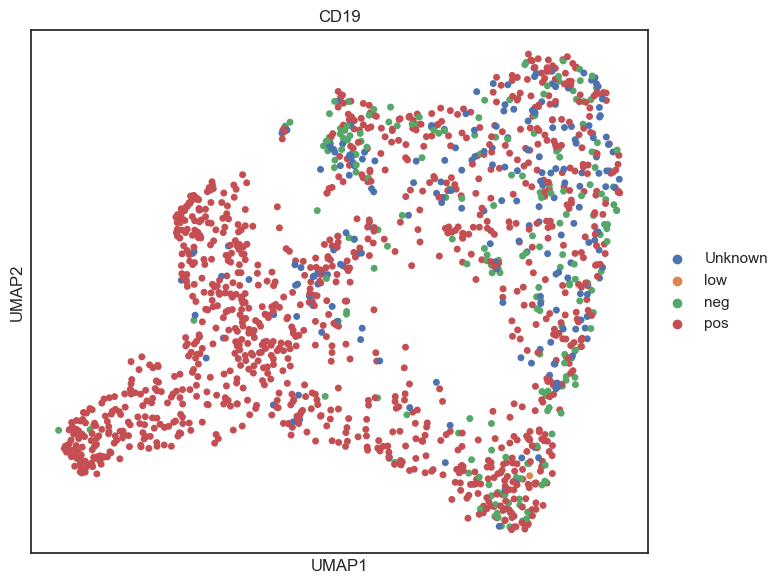

In [352]:
# FOR FINAL FIGURE
# Umap for CD19 expression
with plt.rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList) ], 
                    color=['cd19 expression'],
         show=False, ncols=1,
           size=100)
    ax.set( title="CD19")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_included_cd19.pdf", format="pdf")

### rank_gene_groups

In [88]:
inclusion = []
for i in range(clusterCnt):
    inclusion.append(i)

In [354]:
adata.uns["log1p"]["base"] = None
sc.tl.rank_genes_groups(adata, groupby="leiden_1.0", 
                        method='wilcoxon',
                        groups=clusterList)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


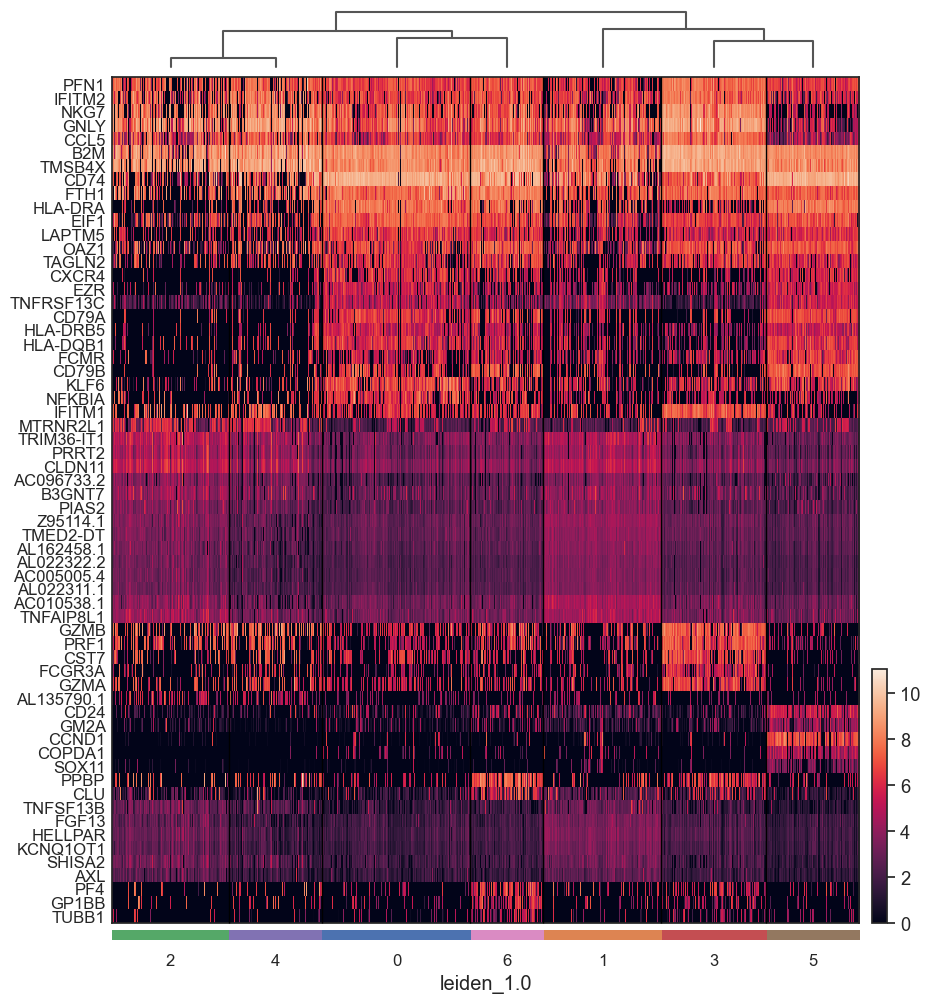

In [424]:
n = 10 # number of markers from each cluster
key = "rank_genes_groups"
clusterList = adata.uns[key]["pvals_adj"].dtype.names
markerSet = set({})
markers = []
logfoldchange = 1
for cluster in clusterList:
    cnt = 0
    for j, g in enumerate(adata.uns[key]["names"][cluster]):
        #print(i, j, g, data.uns["rank_genes_groups"]["pvals_adj"][i][j])
        if (adata.uns[key]["pvals_adj"][cluster][j] >= 0.05):
            continue
        if (g.startswith("RP") or g.startswith("MT-")):
            continue
        if (g not in markerSet):
            markers.append(g)
            markerSet.add(g)
        cnt += 1
        if (cnt >= n):
            break
            
markerAdata = adata.raw.to_adata()[:, markers]
markerX = markerAdata.X.toarray().T

Z = sp.cluster.hierarchy.linkage(markerX, 'complete')
markersReorder = [markers[int(i)] for i in sp.cluster.hierarchy.leaves_list(Z)]

sc.pl.rank_genes_groups_heatmap(adata[adata.obs["leiden_1.0"].isin(clusterList)], 
                       show_gene_labels=True, 
                       key=key, var_names=markersReorder,
                       swap_axes=True, show=False)

plt.savefig("SMART-seq/rank_genes_group_heatmap.pdf", 
                format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


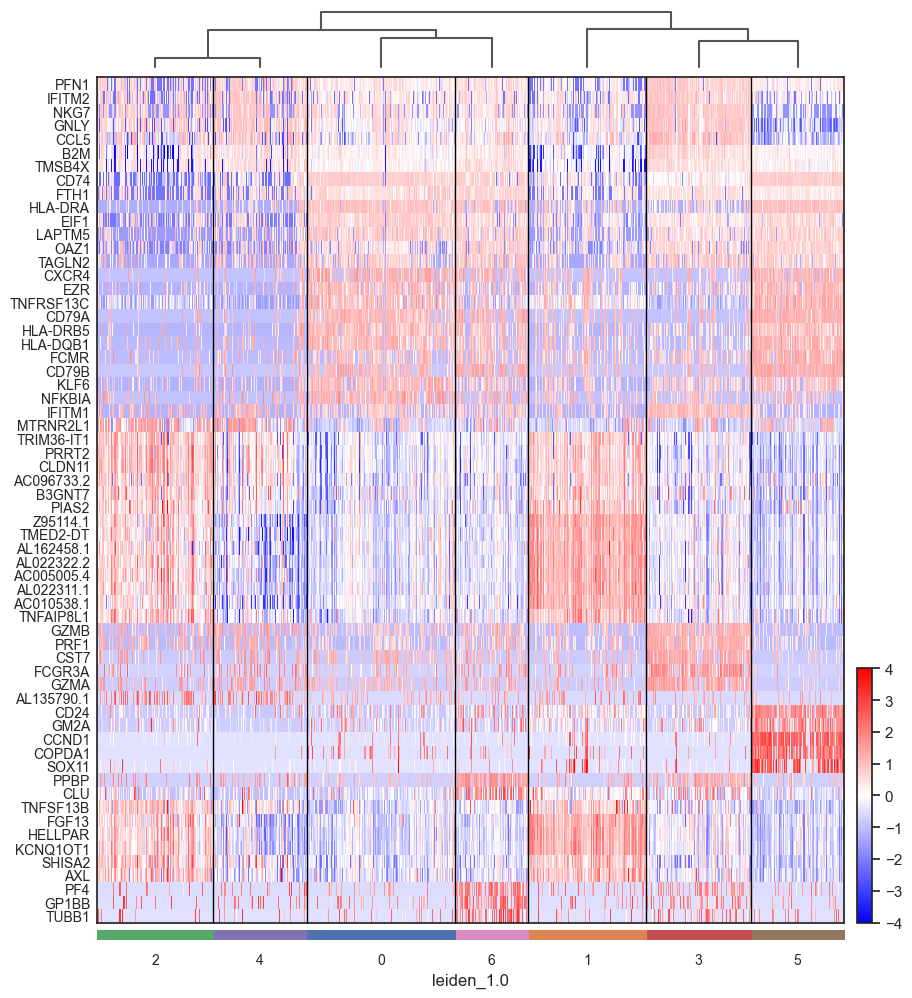

In [411]:
zscoreVisDf = adata.raw.to_adata()[ adata.obs["leiden_1.0"].isin(clusterList)].copy()
zscoreVisDf = zscoreVisDf[:, markers]
sc.pp.scale(zscoreVisDf)

sc.pl.rank_genes_groups_heatmap(zscoreVisDf, 
                       show_gene_labels=True, 
                       key="rank_genes_groups", var_names=markersReorder,
                       swap_axes=True, show=False, cmap="bwr",
                        vmax=4, vmin=-4)
plt.savefig("SMART-seq/rank_genes_group_heatmap_zscore.pdf", 
                format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


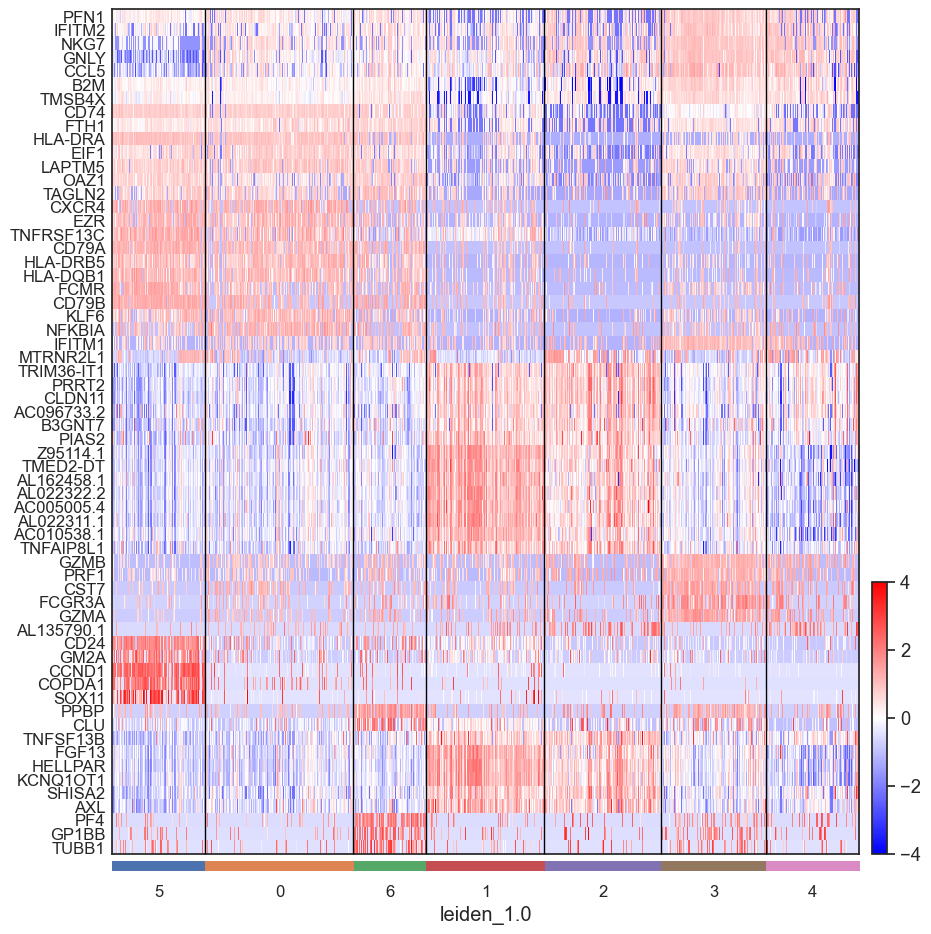

In [429]:
zscoreVisDf = adata.raw.to_adata()[ adata.obs["leiden_1.0"].isin(clusterList)].copy()
zscoreVisDf = zscoreVisDf[:, markers]
sc.pp.scale(zscoreVisDf)
order=['5','0','6','1','2','3','4']
cat_type = pd.api.types.CategoricalDtype(categories=order, ordered=True)
zscoreVisDf.obs["leiden_1.0"] = zscoreVisDf.obs["leiden_1.0"].astype(cat_type)
sc.pl.rank_genes_groups_heatmap(zscoreVisDf, 
                       show_gene_labels=True, 
                       key="rank_genes_groups", var_names=markersReorder,
                       swap_axes=True, show=False, cmap="bwr",
                                dendrogram=False,
                        vmax=4, vmin=-4)
plt.savefig("SMART-seq/rank_genes_group_heatmap_zscore_nodendrogram.pdf", 
                format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


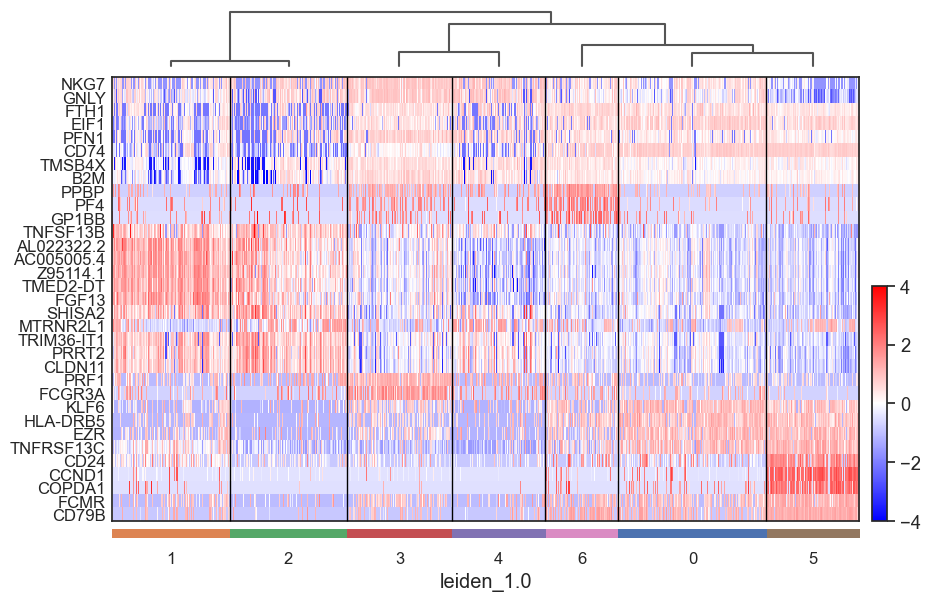

In [415]:
n = 5 # number of markers from each cluster
key = "rank_genes_groups"
clusterList = adata.uns[key]["pvals_adj"].dtype.names
markerSet = set({})
markers = []
logfoldchange = 1
for cluster in clusterList:
    cnt = 0
    for j, g in enumerate(adata.uns[key]["names"][cluster]):
        #print(i, j, g, data.uns["rank_genes_groups"]["pvals_adj"][i][j])
        if (adata.uns[key]["pvals_adj"][cluster][j] >= 0.05):
            continue
        if (g.startswith("RP") or g.startswith("MT-")):
            continue
        if (g not in markerSet):
            markers.append(g)
            markerSet.add(g)
        cnt += 1
        if (cnt >= n):
            break
            
markerAdata = adata.raw.to_adata()[:, markers]
markerX = markerAdata.X.toarray().T

Z = sp.cluster.hierarchy.linkage(markerX, 'complete')
markersReorder = [markers[int(i)] for i in sp.cluster.hierarchy.leaves_list(Z)]

#sc.pl.rank_genes_groups_heatmap(adata[adata.obs["leiden_1.0"].isin(clusterList)], 
#                       show_gene_labels=True, 
#                       key=key, var_names=markersReorder,
#                       swap_axes=True, show=False)

zscoreVisDf = adata.raw.to_adata()[ adata.obs["leiden_1.0"].isin(clusterList)].copy()
zscoreVisDf = zscoreVisDf[:, markers]
sc.pp.scale(zscoreVisDf)

sns.set(font_scale=1.2, style="white")

sc.pl.rank_genes_groups_heatmap(zscoreVisDf, 
                       show_gene_labels=True, 
                       key="rank_genes_groups", var_names=markersReorder,
                       swap_axes=True, show=False, cmap="bwr",
                        vmax=4, vmin=-4)
plt.savefig("SMART-seq/rank_genes_group_heatmap_zscore_3genepercluster.pdf", 
                format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


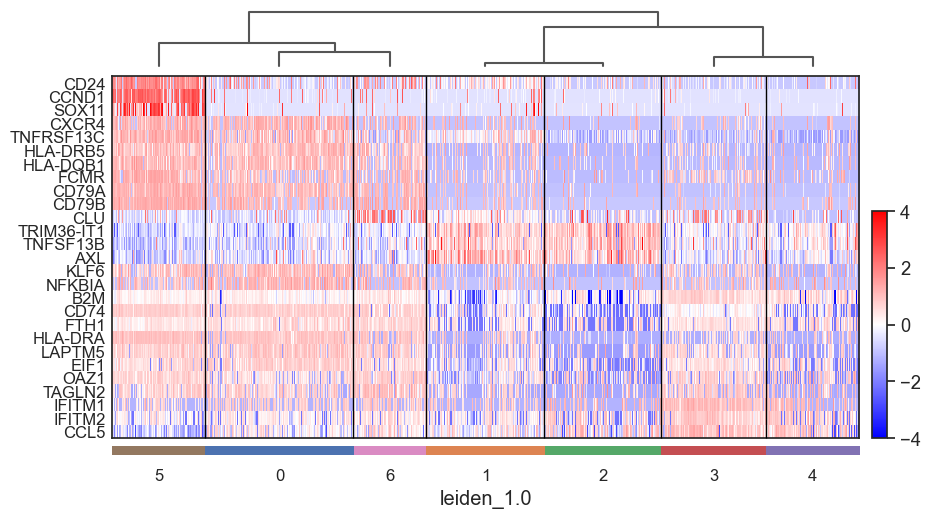

In [423]:
# Use selected gene list
key = "rank_genes_groups"
clusterList = adata.uns[key]["pvals_adj"].dtype.names
markerSet = set({})
#markers = ["B2M", "CD74", "IFITM2", "CCL5", "CD79B", "EZR",
#                  "TNFRSF13C", "HLA-DRB5", "MS4A1", "CD79A", "FCMR",
#                  "PDCD4", "KLF6", "CD37", "HLA-DRA", "HLA-DPA1", "EIF1", "LAPTM5",
#                  "IFITM1", "FRK", "CCDC191", "CD24", "CCND1", "COPDA1", "TNFSF13B"]
markers = ["CD79A", "CD79B", "TNFRSF13C", "HLA-DRA", "HLA-DRB5", "HLA-DQB1",
"FCMR","LAPTM5","CD24","TNFSF13B","CCND1","SOX11","KLF6","CLU","IFITM1",
"IFITM2","CCL5","B2M","NFKBIA","EIF1","CD74","AXL","CXCR4","FTH1",
"TRIM36-IT1","OAZ1","TAGLN2"
]           
markerAdata = adata.raw.to_adata()[:, markers]
markerX = markerAdata.X.toarray().T

Z = sp.cluster.hierarchy.linkage(markerX, 'complete')
markersReorder = [markers[int(i)] for i in sp.cluster.hierarchy.leaves_list(Z)]

#sc.pl.rank_genes_groups_heatmap(adata[adata.obs["leiden_1.0"].isin(clusterList)], 
#                       show_gene_labels=True, 
#                       key=key, var_names=markersReorder,
#                       swap_axes=True, show=False)

zscoreVisDf = adata.raw.to_adata()[ adata.obs["leiden_1.0"].isin(clusterList)].copy()
zscoreVisDf = zscoreVisDf[:, markers]
sc.pp.scale(zscoreVisDf)

sns.set(font_scale=1.2, style="white")

sc.pl.rank_genes_groups_heatmap(zscoreVisDf, 
                       show_gene_labels=True, 
                       key="rank_genes_groups", var_names=markersReorder,
                       swap_axes=True, show=False, cmap="bwr",
                        vmax=4, vmin=-4)
plt.savefig("SMART-seq/rank_genes_group_heatmap_zscore_selectedgene.pdf", 
                format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


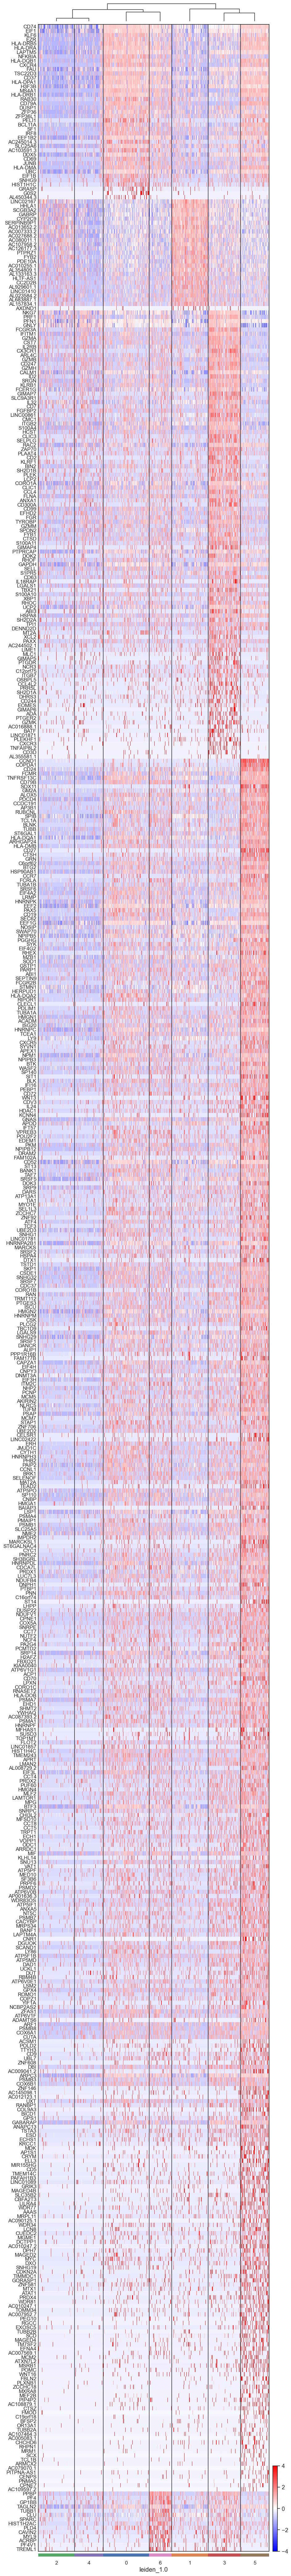

In [92]:
zscoreVisDf = adata.raw.to_adata()[ adata.obs["leiden_1.0"].isin(clusterList)].copy()
zscoreVisDf = zscoreVisDf[:, markers]
sc.pp.scale(zscoreVisDf)

sc.pl.rank_genes_groups_heatmap(zscoreVisDf, 
                       show_gene_labels=True, 
                       key="rank_genes_groups", var_names=list(markers),
                       swap_axes=True, show=False, cmap="bwr",
                        vmin=-4, vmax=4)
plt.savefig("SMART-seq/rank_genes_group_heatmap_full_zscore.pdf", 
                format="pdf")

#### Boxplot for specific genes

In [11]:
gene = "IFITM2"

In [15]:
geneDf = adata.obs[["reduced_time"]]
geneDf["gene"] = adata.raw.X[:, adata.raw.var.index.get_loc(gene)]

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_3695/2130046610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneDf["gene"] = adata.raw.X[:, adata.raw.var.index.get_loc(gene)]


In [14]:
def hollowboxplot(data, x=None, y=None, hue=None, palette=None, ax=None, color=None, 
                  order=None, hue_order=None, jitter=True):
    snsFig = sns.boxplot(x=x, y=y, hue=hue, data=data, hue_order=hue_order, order=order,
                         showfliers = False, palette=palette, ax=ax)
    for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
             snsFig.lines[j].set_color(color)
    if (hue):
        snsFig = sns.stripplot(x=x, y=y, hue=hue, data=data, hue_order=hue_order, order=order,
                             jitter=jitter, dodge=True, palette=palette, ax=snsFig)
    else:
        snsFig = sns.stripplot(x=x, y=y, hue=x, data=data, hue_order=hue_order, order=order,
                             jitter=jitter, dodge=False, palette=palette, ax=snsFig)
    return snsFig

In [16]:
from pvalannot import pvalannot

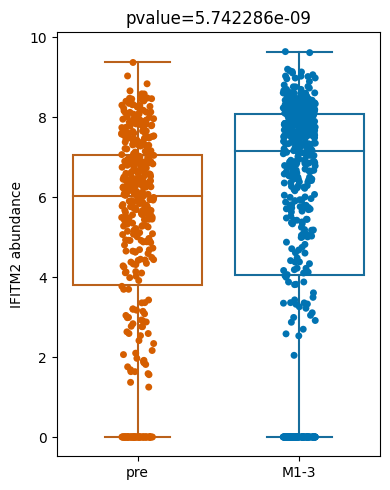

In [17]:
plt.figure(figsize=(4,5))
ax = hollowboxplot(data=geneDf, x="reduced_time", y="gene",
             order=["pre", "M1-3"], palette=reducedTimeColorMap)
#ax.set_rasterized(True)
ax.set(xlabel="", ylabel=gene + " abundance")
ax.get_legend().remove()
ax.set(title="pvalue=%1e"%(sp.stats.mannwhitneyu(geneDf[ geneDf["reduced_time"] == "pre"]["gene"],
                 geneDf[ geneDf["reduced_time"] == "M1-3"]["gene"])[1]))
plt.tight_layout()
plt.savefig( "SMART-seq/" + gene + "_pre_M1-3_comp.pdf")

In [407]:
sp.stats.mannwhitneyu(geneDf[ geneDf["reduced_time"] == "pre"]["gene"],
                 geneDf[ geneDf["reduced_time"] == "M1-3"]["gene"])

MannwhitneyuResult(statistic=87715.5, pvalue=5.7422855775786e-09)

## Add TRUST4 results to adata

In [188]:
trust4Airr = pd.read_csv("pickseq_smartseq_airr_wmeta.tsv", sep="\t", keep_default_na=False)

In [189]:
def GetChainType( v, j, c ):
    s = ""
    if ( v != "*" and v != "" ):
        s = v 
    elif ( j != "*" and v != ""):
        s = j
    elif ( c != "*" and v != ""):
        s = c
    else:
        return -1

    if ( s[0:3] == "IGH" ):
        return 0
    elif ( s[0:3] == "IGK" ):
        return 1
    elif ( s[0:3] == "IGL" ):
        return 1 
    elif ( s[0:3] == "TRA" ):
        return 3
    elif ( s[0:3] == "TRB" ):
        return 4
    elif ( s[0:3] == "TRG" ):
        return 5
    elif ( s[0:3] == "TRD" ):
        return 6
    
    return -1 

def GetGeneType( s ):
    if ( s[3] == "V" ):
        return 0 
    elif ( s[3] == "J" ):
        return 2
    elif (s[3] == "D"):
        if (len(s) == 4):
            return 3
        else:
            return 1
    elif ( s[3] == "-" ):
        return -1
    else:
        return 3
    
chainTypeToName = ("IGH", "IGK", "IGL", "TRA", "TRB", "TRG", "TRD" )
geneTypeToName = ("V", "J", "C" )

def GetMainGeneName( g ): # remove the allele type from the gene name
    fields = g.split( "*", 1 )
    return fields[0]

In [190]:
cellTrustType = {}
for cell in adata.obs.index:
    cellTrustType[cell] = "NA" 
for i, row in trust4Airr.iterrows():
    chainType = GetChainType(row["v_call"], row["j_call"], row["c_call"])
    if (chainType <= 2):
        cellTrustType[row["cell"]] = "B" 
    elif (chainType <= 4):
        cellTrustType[row["cell"]] = "abT"
    elif (chainType <= 6):
        cellTrustType[row["cell"]] = "gdT"
cellTrustDf = pd.DataFrame.from_dict(cellTrustType, orient="index", columns=["t4type"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


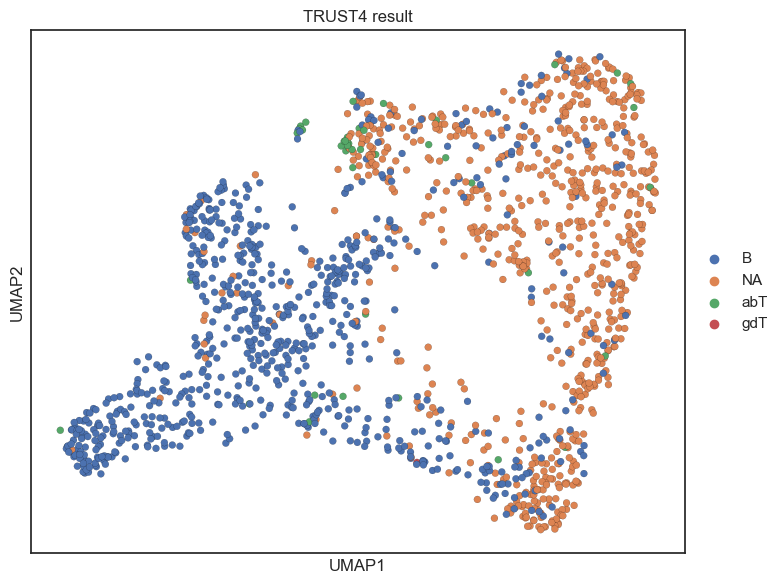

In [192]:
# FOR FINAL FIGURE
# Umap for trust4 assembly result
subAdata = adata[ adata.obs["leiden_1.0"].isin(clusterList) ]
#subAdata.obs["reduced_time"] = subAdata.obs["reduced_time"].astype("category")
#subAdata.obs["reduced_time"] = subAdata.obs["reduced_time"].cat.reorder_categories(selectedTime)
with plt.rc_context({"figure.figsize": (8, 6)}):
    ax = sc.pl.umap(subAdata, color=['t4type'],
         show=False, ncols=1, na_in_legend=False, 
           size=100, linewidth=0.1, edgecolor=[0,0,0])
    ax.set(title="TRUST4 result")
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_t4type.pdf", format="pdf")

### Obtain the sample/cluster clonality and entropy results

In [193]:
locus = []
for i, row in trust4Airr.iterrows():
    if (row["v_call"] != None):
        locus.append(row["v_call"][0:3])
    elif (row["j_call"] != None):
        locus.append(row["j_call"][0:3])
    elif (row["c_call"] != None):
        locus.append(row["c_call"][0:3])
trust4Airr["locus"] = locus

In [196]:
def Entropy(series):
    if (len(series) < 5):
        return np.NaN
    probs = series.value_counts(normalize=True).values
    return -np.sum(probs * np.log2(probs))

def Clonality(series):
    if (len(series) < 5):
        return np.NaN
    if (len(series.value_counts()) == 1):
        return 1
    return 1 - Entropy(series) / np.log2(len(series.value_counts()))

In [197]:
Entropy(adata.obs.loc[ (adata.obs["patient"]=="HD1") & (adata.obs["timepoint"] =="normal") 
              & (adata.obs["leiden_1.0"] == "0") & (adata.obs["junction"].isnull() == False)]["junction"])

5.209453365628953

In [198]:
# Shannon entropy
backupIndex = adata.obs.index

tmpDf = adata.obs[ adata.obs["junction"].isnull() == False ].groupby(["patient", "timepoint", "leiden_1.0"])["junction"].apply(lambda x:Entropy(x)).reset_index()
tmpDf.columns = ["patient", "timepoint", "leiden_1.0", "T4_entropy"]

adata.obs = adata.obs.merge( tmpDf, on=["patient", "timepoint", "leiden_1.0"], how="left")
adata.obs.index = backupIndex

In [199]:
adata.obs

batch patient timepoint picking cd19 expression  \
batch1_S1    batch1     HD1    normal       D             pos   
batch1_S10   batch1     HD1    normal       D             pos   
batch1_S100  batch1   MCL03       pre       S             pos   
batch1_S101  batch1   MCL03       pre       D             pos   
batch1_S102  batch1   MCL03       pre       D             pos   
...             ...     ...       ...     ...             ...   
batch4_S95   batch4   MCL08        M1       D             pos   
batch4_S96   batch4   MCL08        M1       S             pos   
batch4_S97   batch4   MCL08        M1       D             pos   
batch4_S98   batch4   MCL08        M1       D             neg   
batch4_S99   batch4   MCL08        M1       D             pos   

             n_genes_by_counts   total_counts  total_counts_mt  pct_counts_mt  \
batch1_S1                 9753  828690.973979     57756.243776       6.969576   
batch1_S10               10188  854050.840136     38392.017611       4.495285   
batch1_S100              11248  827730.086682     53239.283250       6.431962   
batch1_S101               9026  908373.480852     41163.609974       4.531573   
batch1_S102               4738  889274.342253     34622.911165       3.893389   
...                        ...            ...              ...            ...   
batch4_S95                5706  828051.723576    153651.310291      18.555762   
batch4_S96                6341  755590.221229    143769.890304      19.027495   
batch4_S97                9039  796180.808463     60950.068853       7.655305   
batch4_S98                7781  791343.784788    122691.448853      15.504191   
batch4_S99                9971  770191.843409     71265.097520       9.252902   

            leiden_1.0 raw_pateint reduced_time t4type  \
batch1_S1            0      PBMC13       normal      B   
batch1_S10           0      PBMC13       normal      B   
batch1_S100          3      753528          pre     NA   
batch1_S101          3      753528          pre     NA   
batch1_S102          3      753528          pre     NA   
...                ...         ...          ...    ...   
batch4_S95           4      693381         M1-3     NA   
batch4_S96           2      693381         M1-3     NA   
batch4_S97           2      693381         M1-3     NA   
batch4_S98           2      693381         M1-3     NA   
batch4_S99           2      693381         M1-3     NA   

                                   junction  T4_entropy  
batch1_S1                               NaN    5.209453  
batch1_S10   TGTGCGAAAGACGGATACGATCTAACGTGG    5.209453  
batch1_S100                             NaN         NaN  
batch1_S101                             NaN         NaN  
batch1_S102                             NaN         NaN  
...                                     ...         ...  
batch4_S95                              NaN         NaN  
batch4_S96                              NaN         NaN  
batch4_S97                              NaN         NaN  
batch4_S98                              NaN         NaN  
batch4_S99                              NaN         NaN  

[1683 rows x 15 columns]

In [200]:
# clonality
backupIndex = adata.obs.index
tmpDf = adata.obs[ adata.obs["junction"].isnull() == False ].groupby(["patient", "timepoint", "leiden_1.0"])["junction"].apply(lambda x:Clonality(x)).reset_index()
tmpDf.columns = ["patient", "timepoint", "leiden_1.0", "T4_clonality"]

adata.obs = adata.obs.merge( tmpDf, on=["patient", "timepoint", "leiden_1.0"], how="left")
adata.obs.index = backupIndex

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


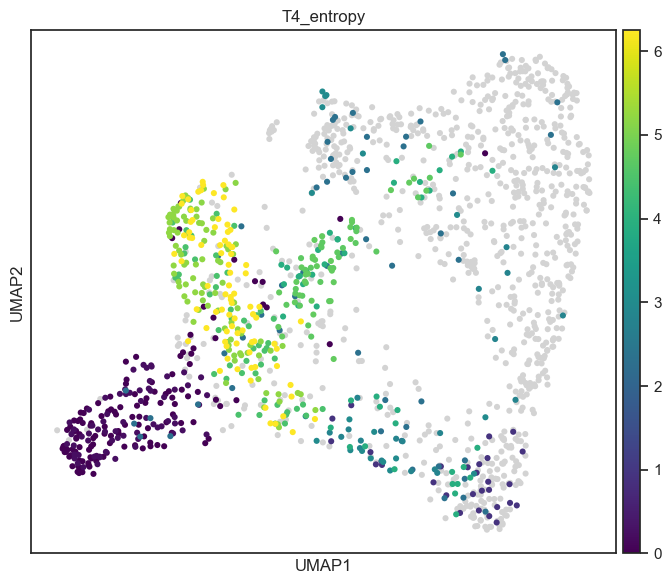

In [210]:
import matplotlib as mpl
with plt.rc_context({"figure.figsize": (7, 6)}):
    sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList)], 
               color=["T4_entropy"],
            show=False, color_map=mpl.cm.viridis)
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_trust4_entropy.pdf", format="pdf")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


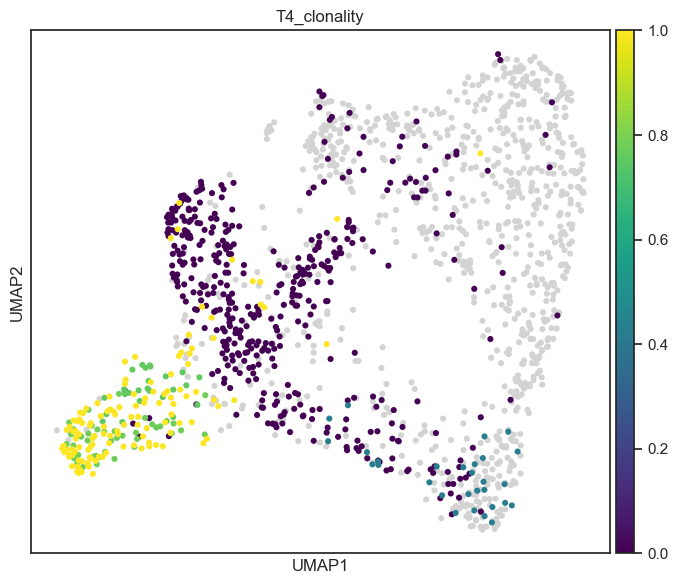

In [204]:
import matplotlib as mpl
with plt.rc_context({"figure.figsize": (7, 6)}):
    sc.pl.umap(adata[ adata.obs["leiden_1.0"].isin(clusterList)], color=["T4_clonality"],
            show=False, color_map=mpl.cm.viridis)
    plt.tight_layout()
    plt.savefig("./SMART-seq/umap_trust4_clonality.pdf", format="pdf")

In [720]:
cancerAdata.obs["cd19 expression"].value_counts()

cd19 expression
pos        915
neg        215
Unknown    178
low          1
Name: count, dtype: int64

In [716]:
np.where(adata.obs["cd19 expression"].cat.categories.values == "low")[0][0]

1

## Explore scSnpMarker

In [18]:
scSnpMarkerDf = pd.DataFrame()
for patientId in ["MCL07", "MCL11"]:
    df = pd.read_csv("scSnpMarker/%s_classify_result_wsampleid_q30.out"%(patientId), sep="\t", 
                     header=None)
    df.columns = ["file_prefix", "class", "pred", "normal", "cancer", "neither", "noinfo", 
                  "cellid", "sampleid"]
    df = df.merge( adata.obs, left_on="cellid", right_index=True)
    scSnpMarkerDf = pd.concat([scSnpMarkerDf, df], ignore_index=True)
    
cases = [(scSnpMarkerDf["normal"] + scSnpMarkerDf["cancer"]<4),
    (scSnpMarkerDf["normal"] > scSnpMarkerDf["cancer"]),
    (scSnpMarkerDf["cancer"] > scSnpMarkerDf["normal"])]
scSnpMarkerDf["pred"] = np.select(cases, [-1, 0, 1], default=-1)

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_2024/227353948.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class+pred'] = np.where(df["class"] != -1, df['class'], df['pred'])
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_2024/227353948.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class+pred'] = np.where(df["class"] != -1, df['class'], df['pred'])


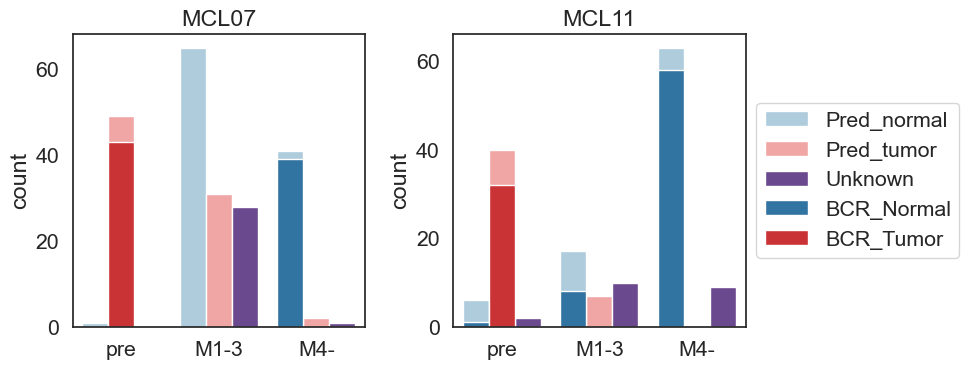

In [190]:
# Final Figure. With all BCR
selectedTime = ["pre", "M1-3", "M4-"]
sns.set(style="white", font_scale=1.4)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
#cases = [(df["normal"] + df["cancer"]<3),
#    (df["normal"] > df["cancer"]),
#    (df["cancer"] > df["normal"])]
#df["pred"] = np.select(cases, [-1, 0, 1], default=-1)
#mypalette = sns.color_palette(None, 5)
#mypalette[0:3] = mypalette[2:5]
hueOrder = [0, 1, -1]
for i,patientId in enumerate(["MCL07", "MCL11"]):
    df = scSnpMarkerDf.loc[ scSnpMarkerDf["patient"] == patientId]
    #df = df[ df["class"] == -1]
    df['class+pred'] = np.where(df["class"] != -1, df['class'], df['pred'])
    pairedPalette = sns.color_palette("Paired", 10)
    
    mypalette = [pairedPalette[x] for x in [0,4,9]]
    ax = sns.countplot(x="reduced_time", data=df, hue="class+pred", ax=axes[i],
                      order=selectedTime, palette=mypalette, hue_order = hueOrder,
                      edgecolor="w")
    
    subdf = df[ df['class'] != -1]
    mypalette = [pairedPalette[x] for x in [1,5,9]]
    ax = sns.countplot(x="reduced_time", data=subdf, hue="class", ax=ax,
                      order=selectedTime, palette=mypalette, hue_order = hueOrder,
                      edgecolor="w")
    
    ax.set(title=patientId, xlabel="")
    ax.set_xticklabels(ax.get_xticklabels())
    if (i == 0):
        ax.get_legend().remove()
    else:
        ax.legend(labels = ["Pred_normal", "Pred_tumor", "Unknown",
                           "BCR_Normal", "BCR_Tumor"],
                            loc="center left", bbox_to_anchor=[1,0.5])
plt.tight_layout()
#plt.savefig("scSnpMarker/scSnpMarker_reduced_timepoint_allstack.pdf", format="pdf",
#           bbox_inches="tight")
plt.show()

In [ ]:
df = scSnpMarkerDf.loc[ (scSnpMarkerDf["patient"] == "MCL07") | (scSnpMarkerDf["patient"]=="MCL11")]
df[ (df["reduced_time"] == "M4-") & (df["class"] == -1)]["pred"].value_counts()

pred
-1    10
 0     7
 1     2
Name: count, dtype: int64

In [ ]:
2/(10+7+2)

0.10526315789473684

In [205]:
31/(65+31+28)

0.25

In [ ]:
# Final figure: Use BCR-labels to validate accuracy
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,10))
for i, patientId in enumerate(["MCL07", "MCL11"]):#, "670730"]:
    df = scSnpMarkerDf.loc[ scSnpMarkerDf["patient"] == patientId]
    df = df[ df["class"] != -1]
    mypalette = [sns.color_palette("Paired", 10)[x] for x in [0,4,9]]
    ax = sns.countplot(x="class", data=df, hue="pred", hue_order=[0, 1, -1],
                      palette = mypalette, ax=axes[i])
    ax.set(title=patientId)
    ax.set_xticklabels(["BCR_normal", "BCR_tumor"])
    ax.set(xlabel="")
    ax.legend(labels = ["Pred_normal", "Pred_tumor", "Unknown"],
                        loc="center left", bbox_to_anchor=[1,0.5])
plt.tight_layout()
plt.savefig("scSnpMarker/scSnpMarker_bcrcell_validation.pdf", format="pdf",
           bbox_inches="tight")
plt.show()
    

In [227]:
df = scSnpMarkerDf.loc[ (scSnpMarkerDf["patient"] == "MCL07") 
                      | (scSnpMarkerDf["patient"] == "MCL11")]
df[ df["class"] == 0]["pred"].value_counts()

pred
 0    93
-1    12
 1     1
Name: count, dtype: int64

In [229]:
df[ df["class"] == 1]["pred"].value_counts()

pred
 1    71
 0     2
-1     2
Name: count, dtype: int64

In [114]:
tmpDf = scSnpMarkerDf[["cellid", "class", "pred"]]
predDescOrder = ["BCR_normal", "BCR_tumor", "Pred_normal", "Pred_tumor", "Unknown"]
cases = [(tmpDf["class"]==0),
         tmpDf["class"] == 1,
    (tmpDf["class"] == -1) & (tmpDf["pred"] == 0),
    (tmpDf["class"] == -1) & (tmpDf["pred"] == 1),
    (tmpDf["class"] == -1) & (tmpDf["pred"] == -1)]
tmpDf["pred_desc"] = np.select(cases, predDescOrder, default="unknown")

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_25964/2530158369.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmpDf["pred_desc"] = np.select(cases, predDescOrder, default="unknown")


In [ ]:
adata

AnnData object with n_obs × n_vars = 1683 × 2000
    obs: 'batch', 'patient', 'timepoint', 'picking', 'cd19 expression', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_1.0', 'raw_pateint', 'reduced_time', 'index_backup', 'junction', 'T4_entropy', 'T4_clonality'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'imrep', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [115]:
subAdata = adata[ adata.obs["patient"].isin(["MCL07", "MCL11"]) ]
subAdata.obs = subAdata.obs.merge(tmpDf, left_index=True, right_on="cellid").set_index("cellid")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


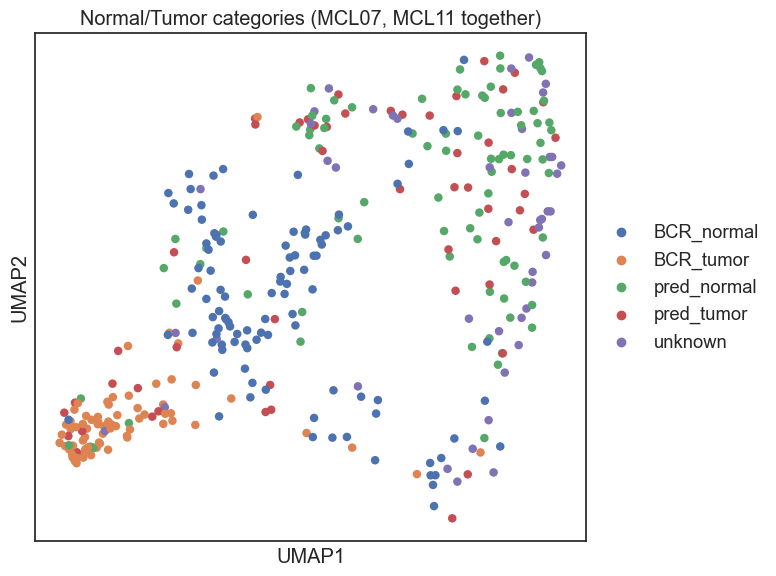

In [ ]:
# UMAP to show the different prediction categories
with plt.rc_context({"figure.figsize": (8, 6)}):
    mypalette = sns.color_palette(None, 5)
    #mypalette[1], mypalette[2] = mypalette[2], mypalette[1]
    ax = sc.pl.umap(subAdata[ subAdata.obs["leiden_1.0"].isin(clusterList)], 
                color=["pred_desc"], palette=mypalette,
                show=False, ncols=1,
               size=150)
    ax.set(title="Normal/Tumor categories (MCL07, MCL11 together)")
plt.tight_layout()
plt.savefig("scSnpMarker/umap_scSnpMarker_all.pdf", format="pdf")

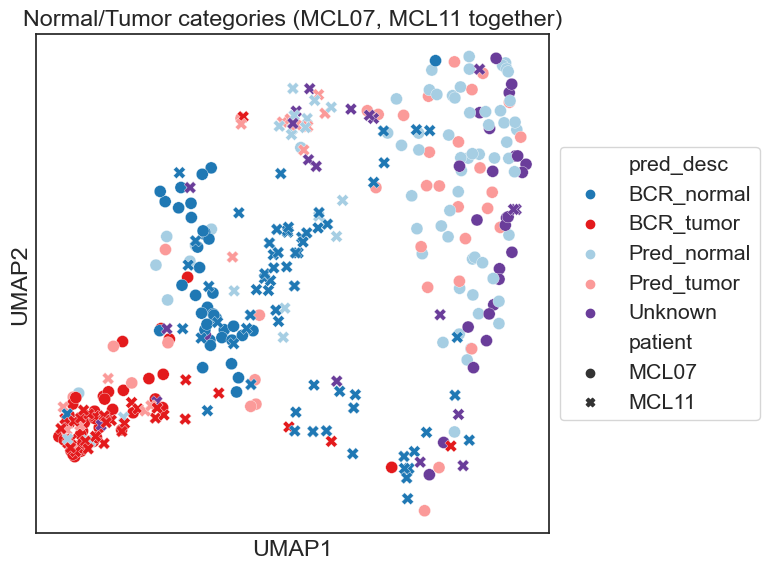

In [131]:
tmpDf = subAdata.obs.copy()
tmpDf["UMAP1"] = subAdata.obsm["X_umap"][:,0]
tmpDf["UMAP2"] = subAdata.obsm["X_umap"][:,1]
mypalette = [sns.color_palette("Paired", 10)[x] for x in [1, 5, 0, 4, 9]]

with plt.rc_context({"figure.figsize": (8, 6)}):
    ax = sns.scatterplot(x="UMAP1", y="UMAP2", data=tmpDf[ tmpDf["leiden_1.0"].isin(clusterList)], 
                   hue="pred_desc", palette=mypalette,
                    style="patient", s=75, linewidth=0.25,
                    hue_order = predDescOrder)
    ax.legend(loc="center left", bbox_to_anchor=[1,0.5])
    
    ax.set(title="Normal/Tumor categories (MCL07, MCL11 together)")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.tight_layout()
plt.savefig("scSnpMarker/umap_scSnpMarker_all.pdf", format="pdf",
           bbox_inches="tight")
plt.show()

In [ ]:
# DEG analysis between post vs pre cancer cells
patientId = "MCL11" # Change this to MCL07 for main fiture
df = scSnpMarkerDf.loc[ scSnpMarkerDf["patient"] == patientId]
cases = [(df["normal"] + df["cancer"]<4),
    (df["normal"] > df["cancer"]),
    (df["cancer"] > df["normal"])]
df["pred0"] = np.select(cases, [-1, 0, 1], default=-1)
df["pred"] = np.where(df["class"] != -1, df["class"], df["pred0"])

cases = [((df["timepoint"] == "pre") & (df["pred"]==1)),
        ((df["timepoint"] != "pre") & (df["pred"]==1))]
df["pre_cancer"] = np.select(cases, ["1", "0"], default="-1")

simpleDf = df[ ["cellid", "pre_cancer"] ]
simpleDf = simpleDf.set_index("cellid")

if ("pre_cancer" in adata.obs.columns):
    adata.obs = adata.obs.drop("pre_cancer", axis=1)
adata.obs = adata.obs.join(simpleDf)
adata.obs["pre_cancer"] = adata.obs["pre_cancer"].astype("category")

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_66954/1027537981.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred0"] = np.select(cases, [-1, 0, 1], default=-1)
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_66954/1027537981.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"] = np.where(df["class"] != -1, df["class"], df["pred0"])
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_66954/1027537981.py:12: SettingWithCopyWarning: 
A value is trying to be se

In [ ]:
# Do DGE on predicted normal, predicted cancer, BCR normal, and BCR cancer

In [ ]:
adata.obs["pre_cancer"].value_counts()

pre_cancer
-1    136
1      49
0      33
Name: count, dtype: int64

In [ ]:
adata.uns["log1p"]["base"] = None
sc.tl.rank_genes_groups(adata, groupby="pre_cancer", 
                        method='wilcoxon',
                        groups=[0, 1])

In [ ]:
n = 15 # number of markers from each cluster
key = "rank_genes_groups"
clusterList = adata.uns[key]["pvals_adj"].dtype.names
markerSet = set({})
markers = []
logfoldchange = 1
pvalCutoff = 0.05
if (patientId == "MCL11"):
    pvalCutoff = 0.4
for cluster in ["0", "1"]:
    cnt = 0
    for j, g in enumerate(adata.uns[key]["names"][cluster]):
        #print(i, j, g, data.uns["rank_genes_groups"]["pvals_adj"][i][j])
        if (adata.uns[key]["pvals_adj"][cluster][j] >= pvalCutoff
           or adata.uns[key]["logfoldchanges"][cluster][j] < 1):
            continue
        if (g.startswith("RP") or g.startswith("MT-")):
            continue
        if (g not in markerSet):
            markers.append(g)
            markerSet.add(g)
        cnt += 1
        if (cnt >= n):
            break
    print(cnt)
#sc.pl.rank_genes_groups_heatmap(adata[adata.obs["pre_cancer"].isin([0.0, 1.0])], 
#                       show_gene_labels=True, 
#                       key=key, var_names=list(markers),
#                       swap_axes=True, show=False)

15
15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


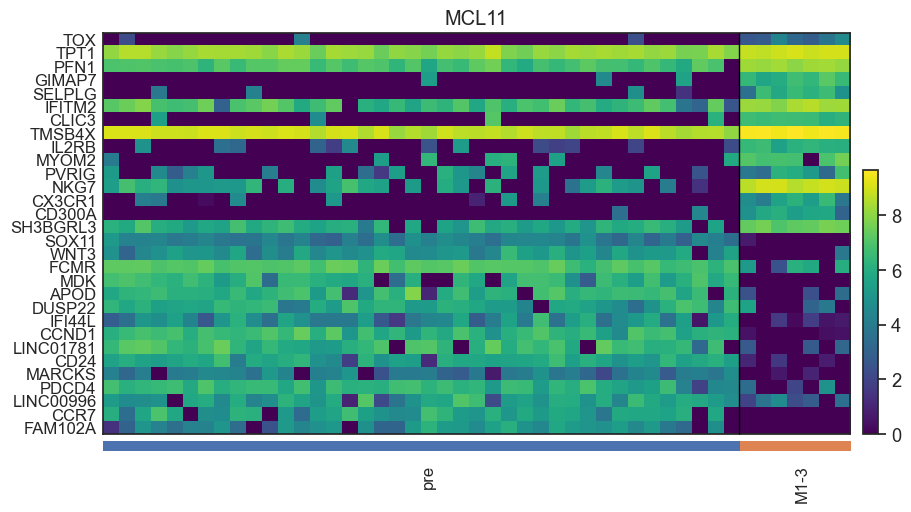

In [ ]:
adata.obs["reduced_time"] = adata.obs["reduced_time"].cat.reorder_categories(["normal", "pre", "M1-3", "M4-"])
ax = sc.pl.heatmap(adata[adata.obs["pre_cancer"].isin(["0", "1"])], 
                       groupby="reduced_time", 
                       show_gene_labels=True, 
                       var_names=list(markers),
                       swap_axes=True, show=False, cmap="viridis")
ax["heatmap_ax"].set(title=patientId)
ax["groupby_ax"].set(xlabel="")

plt.savefig(f"scSnpMarker/heatmap_scSnpMarker_prepost_cancer_{patientId}.pdf", format="pdf",
           bbox_inches="tight")

## End